In [1]:
#basic imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import classification_report,accuracy_score,f1_score,roc_auc_score

In [2]:
warnings.filterwarnings('ignore')

In [3]:
device = torch.device("mps")

In [4]:
df = pd.read_csv('weatherAUS-2.csv')

In [5]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [6]:
df.drop(['Evaporation','Sunshine'],axis=1,inplace=True)

In [7]:
df.dropna(inplace=True)

In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
MinTemp,71045.0,13.195977,6.447023,-6.7,8.3,12.9,18.1,31.4
MaxTemp,71045.0,23.843106,7.160639,4.1,18.2,23.4,29.3,48.1
Rainfall,71045.0,2.653144,9.495474,0.0,0.0,0.0,1.0,367.6
WindGustSpeed,71045.0,41.056316,13.371500,9.0,31.0,39.0,48.0,126.0
WindSpeed9am,71045.0,15.771595,8.308285,2.0,9.0,15.0,20.0,69.0
WindSpeed3pm,71045.0,19.765360,8.540903,2.0,13.0,19.0,26.0,76.0
Humidity9am,71045.0,67.082230,19.030765,0.0,55.0,68.0,81.0,100.0
Humidity3pm,71045.0,50.660412,20.929371,0.0,36.0,51.0,65.0,100.0
Pressure9am,71045.0,1017.193739,6.975855,980.5,1012.6,1017.1,1021.9,1040.4
Pressure3pm,71045.0,1014.810935,6.931394,977.1,1010.0,1014.7,1019.5,1038.9


In [9]:
from ydata_profiling import ProfileReport
report = ProfileReport(df)
#report

In [10]:
df['Date'] = pd.to_datetime(df['Date'])

In [11]:
df['Date']

4        2008-12-05
11       2008-12-12
12       2008-12-13
16       2008-12-17
17       2008-12-18
            ...    
145398   2017-04-25
145428   2017-05-25
145432   2017-05-29
145433   2017-05-30
145458   2017-06-24
Name: Date, Length: 71045, dtype: datetime64[ns]

In [12]:
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

In [13]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,...,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Year,Month,Day
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,...,1006.0,7.0,8.0,17.8,29.7,No,No,2008,12,5
11,2008-12-12,Albury,15.9,21.7,2.2,NNE,31.0,NE,ENE,15.0,...,1004.2,8.0,8.0,15.9,17.0,Yes,Yes,2008,12,12
12,2008-12-13,Albury,15.9,18.6,15.6,W,61.0,NNW,NNW,28.0,...,993.0,8.0,8.0,17.4,15.8,Yes,Yes,2008,12,13
16,2008-12-17,Albury,14.1,20.9,0.0,ENE,22.0,SSW,E,11.0,...,1010.4,8.0,1.0,17.2,18.1,No,Yes,2008,12,17
17,2008-12-18,Albury,13.5,22.9,16.8,W,63.0,N,WNW,6.0,...,1002.2,8.0,1.0,18.0,21.5,Yes,Yes,2008,12,18


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71045 entries, 4 to 145458
Data columns (total 24 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           71045 non-null  datetime64[ns]
 1   Location       71045 non-null  object        
 2   MinTemp        71045 non-null  float64       
 3   MaxTemp        71045 non-null  float64       
 4   Rainfall       71045 non-null  float64       
 5   WindGustDir    71045 non-null  object        
 6   WindGustSpeed  71045 non-null  float64       
 7   WindDir9am     71045 non-null  object        
 8   WindDir3pm     71045 non-null  object        
 9   WindSpeed9am   71045 non-null  float64       
 10  WindSpeed3pm   71045 non-null  float64       
 11  Humidity9am    71045 non-null  float64       
 12  Humidity3pm    71045 non-null  float64       
 13  Pressure9am    71045 non-null  float64       
 14  Pressure3pm    71045 non-null  float64       
 15  Cloud9am       71045 no

In [15]:
df['Delta_Temp_day'] = abs(df['MaxTemp'] - df['MinTemp'])
df['Delta_Temp_6hr'] = abs(df['Temp9am'] - df['Temp3pm'])

In [16]:
df['Wind_dir_change'] = df['WindDir9am'] != df['WindDir3pm']

In [17]:
df['Wind_dir_change'].value_counts()

Wind_dir_change
True     58305
False    12740
Name: count, dtype: int64

In [18]:
df['Delta_wind_speed_6hr'] = abs(df['WindSpeed9am'] - df['WindSpeed3pm'])

In [19]:
df['Delta_humidity_6hr'] = abs(df['Humidity9am'] - df['Humidity3pm']) 

In [20]:
df['Delta_Pressure_6hr'] = abs(df['Pressure9am'] - df['Pressure3pm'])

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71045 entries, 4 to 145458
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  71045 non-null  datetime64[ns]
 1   Location              71045 non-null  object        
 2   MinTemp               71045 non-null  float64       
 3   MaxTemp               71045 non-null  float64       
 4   Rainfall              71045 non-null  float64       
 5   WindGustDir           71045 non-null  object        
 6   WindGustSpeed         71045 non-null  float64       
 7   WindDir9am            71045 non-null  object        
 8   WindDir3pm            71045 non-null  object        
 9   WindSpeed9am          71045 non-null  float64       
 10  WindSpeed3pm          71045 non-null  float64       
 11  Humidity9am           71045 non-null  float64       
 12  Humidity3pm           71045 non-null  float64       
 13  Pressure9am         

In [22]:
location_rain = df.groupby('Location')['Rainfall'].mean()

In [23]:
df['Location_mean'] = df['Location'].apply(lambda x : location_rain[x])

In [24]:
location_month_rain = df.groupby(['Location','Month'])['Rainfall'].mean()

In [25]:
def monthly_loc_rain(cols):
    loc = cols[0]
    month = cols[1]
    
    return location_month_rain[loc][month]

In [26]:
df['Location_month_rain'] = df[['Location','Month']].apply(monthly_loc_rain,axis=1)

In [27]:
location_year_rain = df.groupby(['Location','Year'])['Rainfall'].mean()
def yearly_loc_rain(cols):
    loc = cols[0]
    yr = cols[1]
    return location_year_rain[loc][yr]

In [28]:
df['Location_yr_rain'] = df[['Location','Year']].apply(yearly_loc_rain,axis=1)

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71045 entries, 4 to 145458
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Date                  71045 non-null  datetime64[ns]
 1   Location              71045 non-null  object        
 2   MinTemp               71045 non-null  float64       
 3   MaxTemp               71045 non-null  float64       
 4   Rainfall              71045 non-null  float64       
 5   WindGustDir           71045 non-null  object        
 6   WindGustSpeed         71045 non-null  float64       
 7   WindDir9am            71045 non-null  object        
 8   WindDir3pm            71045 non-null  object        
 9   WindSpeed9am          71045 non-null  float64       
 10  WindSpeed3pm          71045 non-null  float64       
 11  Humidity9am           71045 non-null  float64       
 12  Humidity3pm           71045 non-null  float64       
 13  Pressure9am         

In [30]:
df.drop('Date',axis=1,inplace=True)

In [31]:
from sklearn.preprocessing import LabelEncoder
lbl_en = LabelEncoder()

In [32]:
df.head()

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,...,Day,Delta_Temp_day,Delta_Temp_6hr,Wind_dir_change,Delta_wind_speed_6hr,Delta_humidity_6hr,Delta_Pressure_6hr,Location_mean,Location_month_rain,Location_yr_rain
4,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,...,5,14.8,11.9,True,13.0,49.0,4.8,4.653401,3.42381,6.133333
11,Albury,15.9,21.7,2.2,NNE,31.0,NE,ENE,15.0,13.0,...,12,5.8,1.1,True,2.0,2.0,6.3,4.653401,3.42381,6.133333
12,Albury,15.9,18.6,15.6,W,61.0,NNW,NNW,28.0,28.0,...,13,2.7,1.6,False,0.0,17.0,1.3,4.653401,3.42381,6.133333
16,Albury,14.1,20.9,0.0,ENE,22.0,SSW,E,11.0,9.0,...,17,6.8,0.9,True,2.0,13.0,1.8,4.653401,3.42381,6.133333
17,Albury,13.5,22.9,16.8,W,63.0,N,WNW,6.0,20.0,...,18,9.4,3.5,True,14.0,15.0,3.6,4.653401,3.42381,6.133333


In [33]:
cols_to_enc = ['Location','WindGustDir','WindDir9am','WindDir3pm','RainToday','RainTomorrow','Wind_dir_change']

In [34]:
for col in cols_to_enc:
    df[col] = lbl_en.fit_transform(df[col])

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 71045 entries, 4 to 145458
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Location              71045 non-null  int64  
 1   MinTemp               71045 non-null  float64
 2   MaxTemp               71045 non-null  float64
 3   Rainfall              71045 non-null  float64
 4   WindGustDir           71045 non-null  int64  
 5   WindGustSpeed         71045 non-null  float64
 6   WindDir9am            71045 non-null  int64  
 7   WindDir3pm            71045 non-null  int64  
 8   WindSpeed9am          71045 non-null  float64
 9   WindSpeed3pm          71045 non-null  float64
 10  Humidity9am           71045 non-null  float64
 11  Humidity3pm           71045 non-null  float64
 12  Pressure9am           71045 non-null  float64
 13  Pressure3pm           71045 non-null  float64
 14  Cloud9am              71045 non-null  float64
 15  Cloud3pm              7

In [36]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Location,71045.0,16.314646,9.399178,0.000000,8.000000,16.000000,24.000000,33.000000
MinTemp,71045.0,13.195977,6.447023,-6.700000,8.300000,12.900000,18.100000,31.400000
MaxTemp,71045.0,23.843106,7.160639,4.100000,18.200000,23.400000,29.300000,48.100000
Rainfall,71045.0,2.653144,9.495474,0.000000,0.000000,0.000000,1.000000,367.600000
WindGustDir,71045.0,7.603800,4.783777,0.000000,3.000000,8.000000,12.000000,15.000000
WindGustSpeed,71045.0,41.056316,13.371500,9.000000,31.000000,39.000000,48.000000,126.000000
WindDir9am,71045.0,7.205827,4.635691,0.000000,3.000000,7.000000,11.000000,15.000000
WindDir3pm,71045.0,7.697178,4.699855,0.000000,3.000000,8.000000,12.000000,15.000000
WindSpeed9am,71045.0,15.771595,8.308285,2.000000,9.000000,15.000000,20.000000,69.000000
WindSpeed3pm,71045.0,19.765360,8.540903,2.000000,13.000000,19.000000,26.000000,76.000000


In [37]:
for col in df.columns:
    if df[col].dtype == "int64" or df[col].dtype == "int32" :
        df[col] = df[col].astype('int16')
    else:
        df[col] = df[col].astype('float16')

In [38]:
cat_cols = ['Location','WindGustDir','WindDir9am', 'WindDir3pm','RainToday','Year', 'Month', 'Day','Wind_dir_change']
num_cols = ['MinTemp', 'MaxTemp', 'Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm','Delta_Temp_day', 'Delta_Temp_6hr','Delta_wind_speed_6hr', 'Delta_humidity_6hr','Delta_Pressure_6hr', 'Location_mean', 'Location_month_rain','Location_yr_rain']
target = ['RainTomorrow']

<Axes: xlabel='RainTomorrow', ylabel='count'>

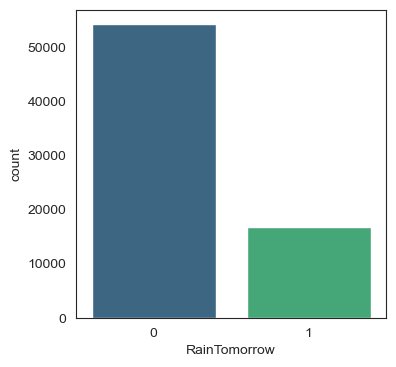

In [39]:
plt.figure(figsize=(4,4))
sns.set_style('white')
sns.countplot(x='RainTomorrow',data=df,palette='viridis')

In [40]:
def plot_box(df):
    numerical_cols = ['MinTemp', 'MaxTemp', 'Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm','Delta_Temp_day', 'Delta_Temp_6hr','Delta_wind_speed_6hr', 'Delta_humidity_6hr','Delta_Pressure_6hr', 'Location_mean', 'Location_month_rain','Location_yr_rain']
    num_plots = len(numerical_cols)
    nrows = (num_plots+1)//2
    ncols = 2
    fig, axes = plt.subplots(figsize=(20,40),nrows=nrows,ncols=ncols,facecolor='black')
    for i,column in enumerate(numerical_cols):
        row = i//2
        col = i%2
        ax = axes[row,col]
        ax.set_facecolor('black')
        sns.boxplot(x='RainTomorrow',y=column,data=df,palette='rocket', linewidth=2.5, saturation=0.9,ax=ax,width=0.55)
        ax.set_title(f'Boxplot of {column}', color='white', fontsize=14, weight='bold')
        ax.set_xlabel(f'{column}', color='white', fontsize=12)
        ax.set_ylabel('Values', color='white', fontsize=12)
        
        ax.tick_params(axis='x', colors='white', labelsize=10)
        ax.tick_params(axis='y', colors='white', labelsize=10)
        
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
        
        # Handle legend if present
        legend = ax.get_legend()
        if legend is not None:
            legend.get_frame().set_facecolor('black')
            legend.get_frame().set_edgecolor('white')
            plt.setp(legend.get_texts(), color='white')
    plt.tight_layout()
    plt.show()

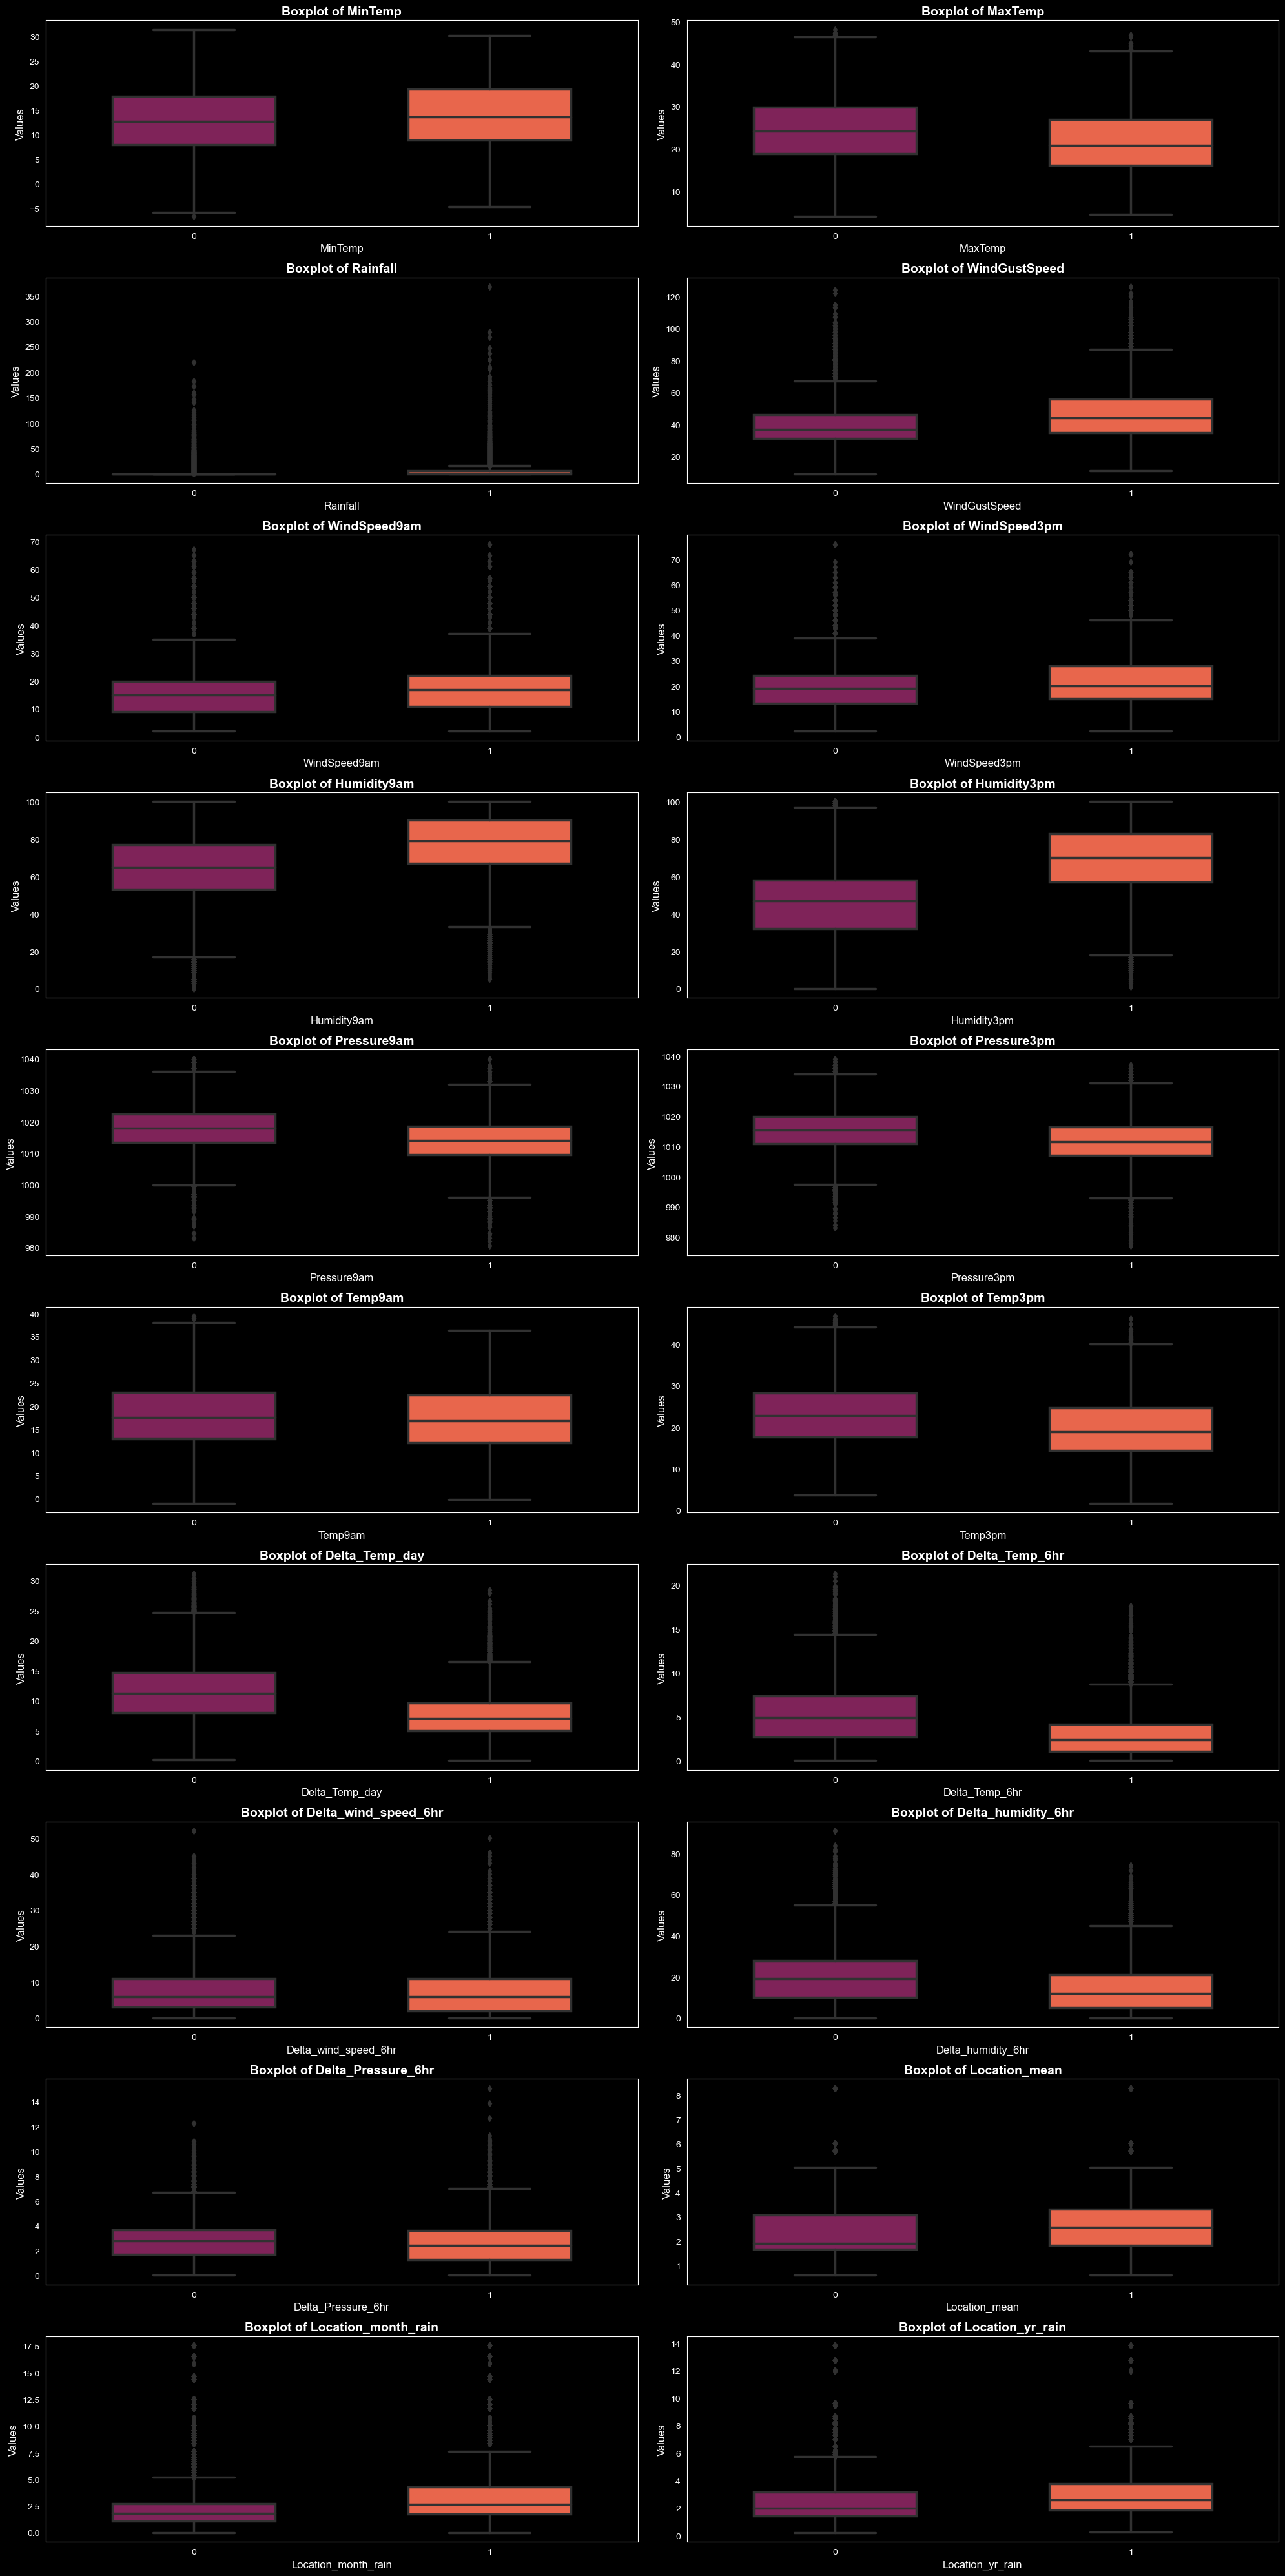

In [41]:
plot_box(df)

In [42]:
def plot_dist(df):
    numerical_cols = ['MinTemp', 'MaxTemp', 'Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am','Pressure3pm', 'Temp9am', 'Temp3pm','Delta_Temp_day', 'Delta_Temp_6hr','Delta_wind_speed_6hr', 'Delta_humidity_6hr','Delta_Pressure_6hr', 'Location_mean', 'Location_month_rain','Location_yr_rain']
    num_plots = len(numerical_cols)
    nrows = (num_plots+1)//2
    ncols = 2
    fig, axes = plt.subplots(figsize=(20,40),nrows=nrows,ncols=ncols,facecolor='black')
    for i,column in enumerate(numerical_cols):
        row = i//2
        col = i%2
        ax = axes[row,col]
        ax.set_facecolor('black')
        sns.histplot(x=df[column].astype('float64'),palette='viridis', linewidth=0.8,bins=80,kde=True,ax=ax,hue=df['RainTomorrow'])
        ax.set_title(f'Distplot of {column}', color='white', fontsize=14, weight='bold')
        ax.set_xlabel(f'{column}', color='white', fontsize=12)
        ax.set_ylabel('Values', color='white', fontsize=12)
        
        ax.tick_params(axis='x', colors='white', labelsize=10)
        ax.tick_params(axis='y', colors='white', labelsize=10)
        
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
        
        # Handle legend if present
        legend = ax.get_legend()
        if legend is not None:
            legend.get_frame().set_facecolor('black')
            legend.get_frame().set_edgecolor('white')
            plt.setp(legend.get_texts(), color='white')
    plt.tight_layout()
    plt.show()

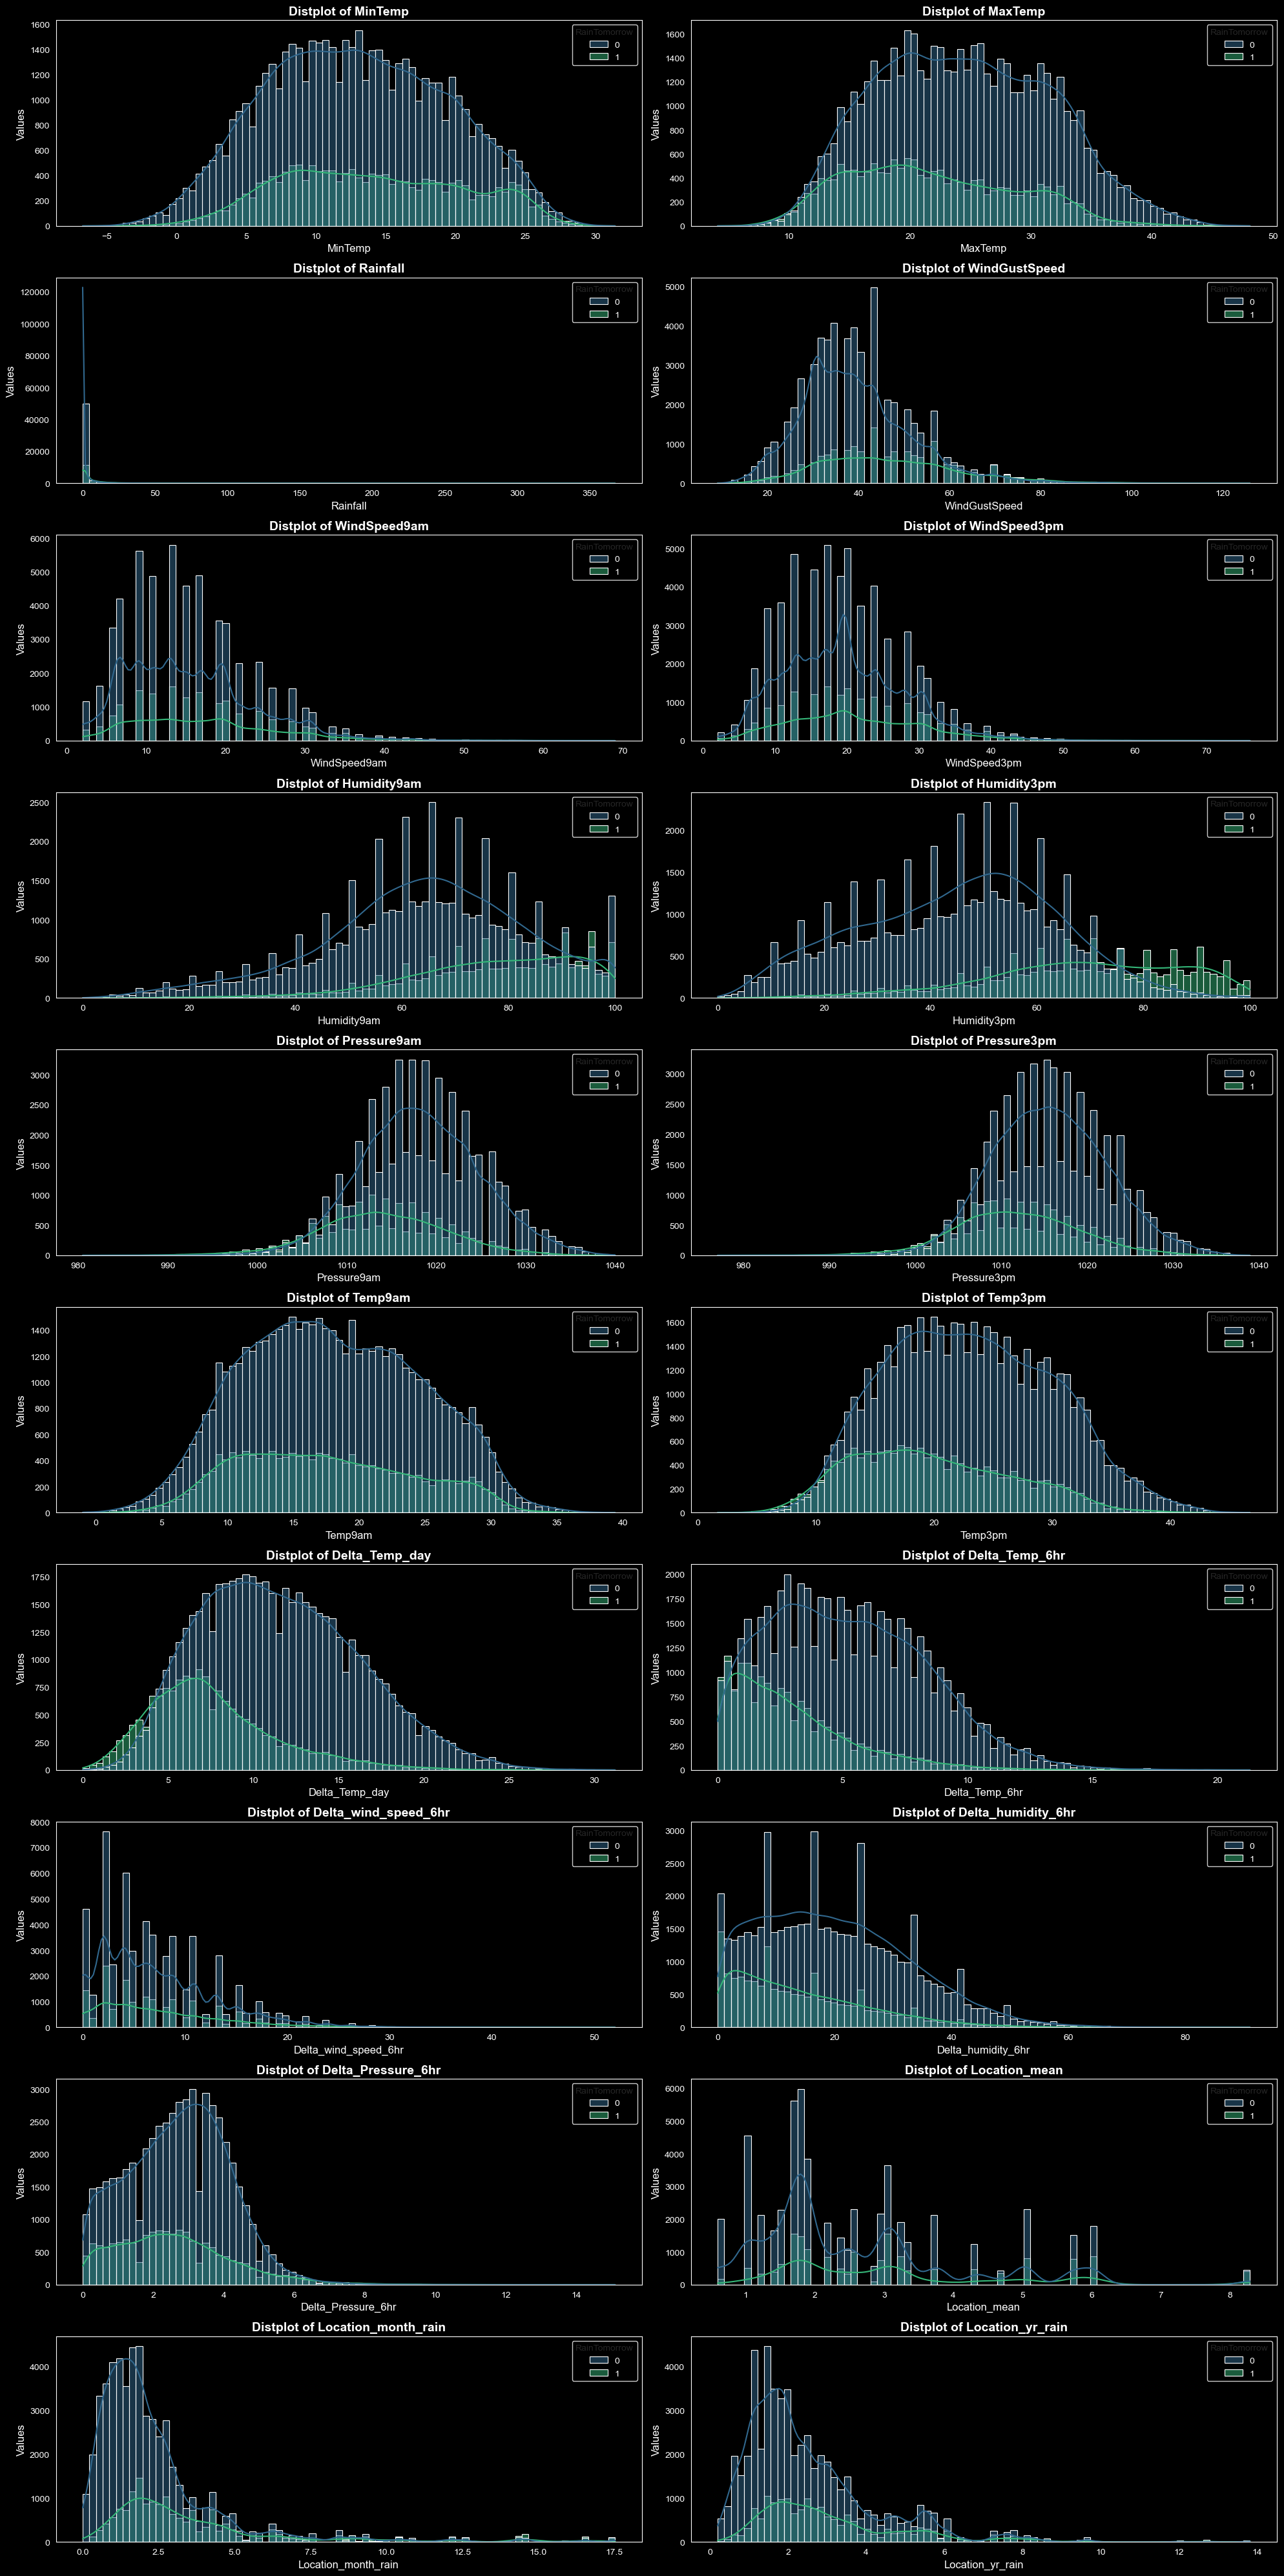

In [43]:
plot_dist(df)

In [44]:
def plot_count(df):
    cat_cols = ['Location','WindGustDir','WindDir9am', 'WindDir3pm','RainToday','Year', 'Month', 'Day','Wind_dir_change']
    num_plots = len(cat_cols)
    nrows = (num_plots+1)//2
    ncols = 2
    fig, axes = plt.subplots(figsize=(20,40),nrows=nrows,ncols=ncols,facecolor='black')
    for i,column in enumerate(cat_cols):
        row = i//2
        col = i%2
        ax = axes[row,col]
        ax.set_facecolor('black')
        sns.countplot(x=df[column],palette='winter',ax=ax)
        ax.set_title(f'Distplot of {column}', color='white', fontsize=14, weight='bold')
        ax.set_xlabel(f'{column}', color='white', fontsize=12)
        ax.set_ylabel('Values', color='white', fontsize=12)
        
        ax.tick_params(axis='x', colors='white', labelsize=10)
        ax.tick_params(axis='y', colors='white', labelsize=10)
        
        for spine in ax.spines.values():
            spine.set_edgecolor('white')
        
        # Handle legend if present
        legend = ax.get_legend()
        if legend is not None:
            legend.get_frame().set_facecolor('black')
            legend.get_frame().set_edgecolor('white')
            plt.setp(legend.get_texts(), color='white')
    plt.tight_layout()
    plt.show()

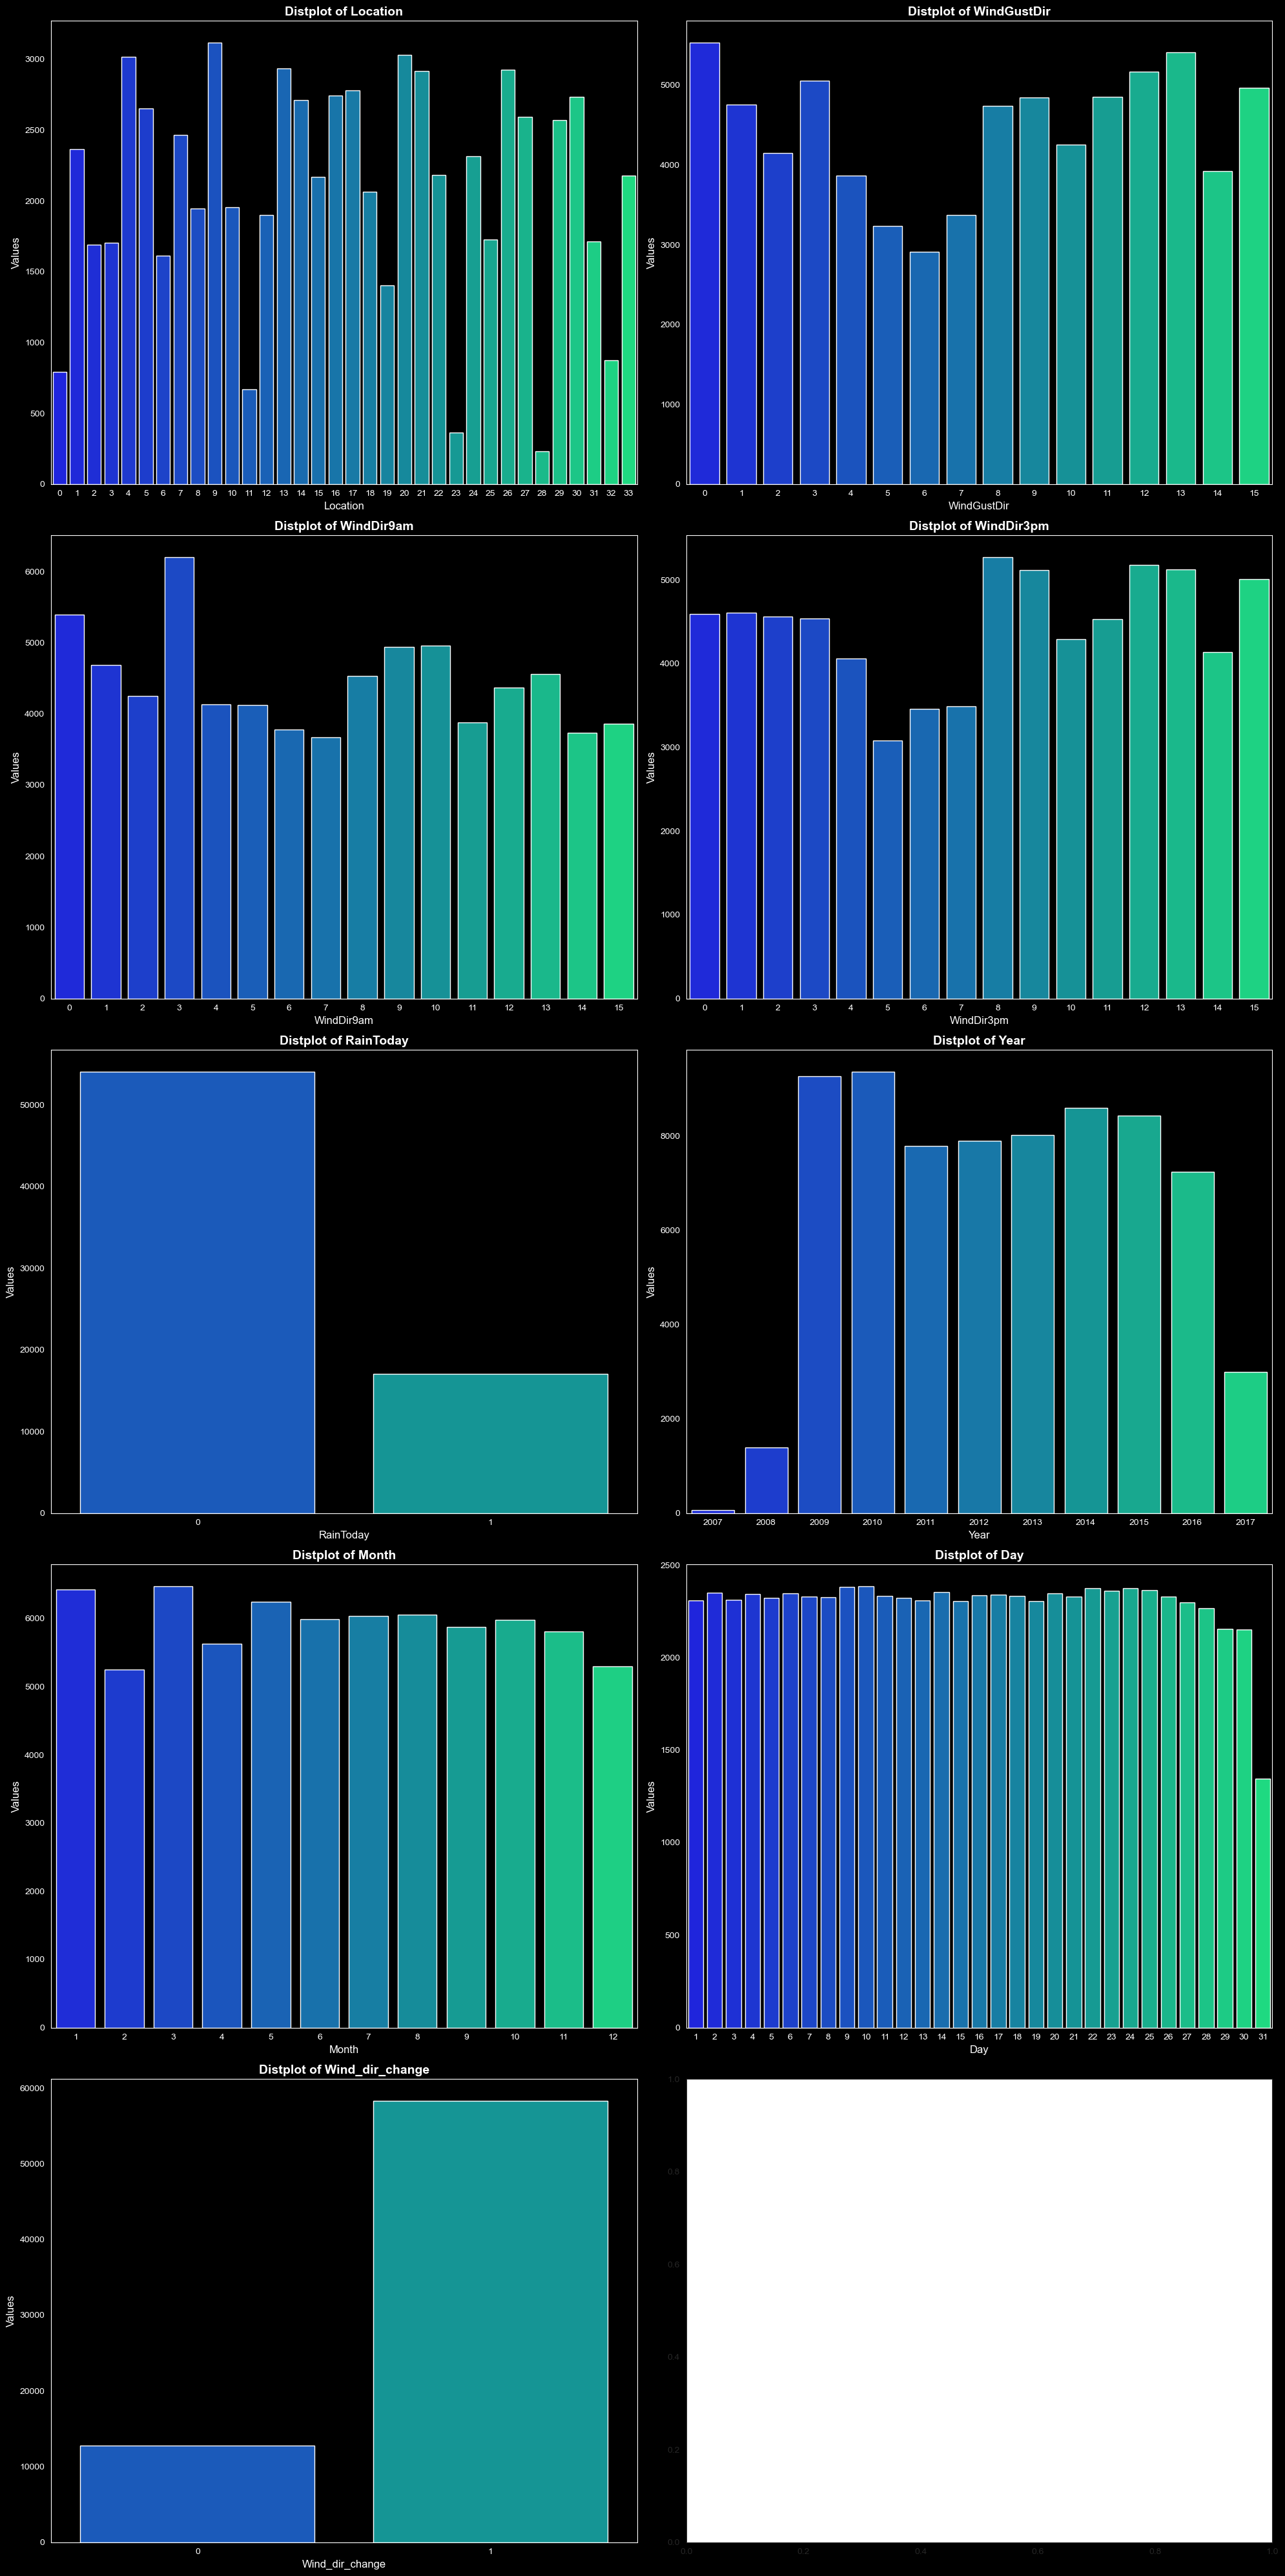

In [45]:
plot_count(df)

<Axes: >

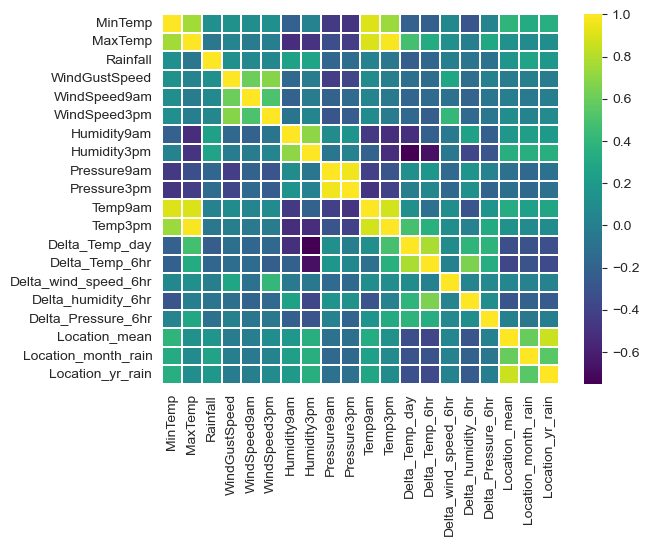

In [46]:
sns.heatmap(df[num_cols].corr(),cmap='viridis',linecolor='white',linewidths=1.2)

### data splitting

In [47]:
def remove_outliers(df,columns,k=1.5):
    "function to remove outliers using IQR method"
    #calculate q1(first quartile) and q3(third quartile)
    for column in columns:
        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)
        #calculate inter-quartile range 
        iqr = q3-q1
        #remove values which lie below q1-1.5(iqr) and above q3+1.5(iqr)
        df[column] = df[column].clip(lower = q1 - k*iqr, upper = q3 + k+iqr)
    return df

In [48]:
df = remove_outliers(df,num_cols)

In [53]:
df.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'WindGustDir',
       'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm',
       'RainToday', 'RainTomorrow', 'Year', 'Month', 'Day', 'Delta_Temp_day',
       'Delta_Temp_6hr', 'Wind_dir_change', 'Delta_wind_speed_6hr',
       'Delta_humidity_6hr', 'Delta_Pressure_6hr', 'Location_mean',
       'Location_month_rain', 'Location_yr_rain'],
      dtype='object')

In [56]:
X = df.drop('RainTomorrow',axis=1)
y = df['RainTomorrow']

In [57]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,stratify=y_train)

In [58]:
from sklearn.preprocessing import StandardScaler
st_sclr = StandardScaler()
X_train = st_sclr.fit_transform(X_train)
X_test = st_sclr.transform(X_test)
X_val = st_sclr.transform(X_val)

In [59]:
from imblearn.over_sampling import ADASYN,SMOTE,RandomOverSampler,KMeansSMOTE,SVMSMOTE
from collections import Counter

In [60]:
counter = Counter(y_train)
print("Before",counter)
ada = ADASYN()
X_train_ada,y_train_ada = ada.fit_resample(X_train,y_train)
counter = Counter(y_train_ada)
print("After",counter)
X_train_ada,X_val_ada,y_train_ada,y_val_ada = train_test_split(X_train_ada,y_train_ada,test_size=0.2,stratify=y_train_ada)

Before Counter({0: 30403, 1: 9381})
After Counter({1: 30581, 0: 30403})


In [61]:
counter = Counter(y_train)
print("Before",counter)
smote = SMOTE()
X_train_smt,y_train_smt = smote.fit_resample(X_train,y_train)
counter = Counter(y_train_smt)
print("After",counter)
X_train_smt,X_val_smt,y_train_smt,y_val_smt = train_test_split(X_train_smt,y_train_smt,test_size=0.2,stratify=y_train_smt)

Before Counter({0: 30403, 1: 9381})
After Counter({1: 30403, 0: 30403})


In [62]:
counter = Counter(y_train)
print("Before",counter)
rnd = RandomOverSampler()
X_train_rnd,y_train_rnd = rnd.fit_resample(X_train,y_train)
counter = Counter(y_train_rnd)
print("After",counter)
X_train_rnd,X_val_rnd,y_train_rnd,y_val_rnd = train_test_split(X_train_rnd,y_train_rnd,test_size=0.2,stratify=y_train_rnd)

Before Counter({0: 30403, 1: 9381})
After Counter({1: 30403, 0: 30403})


In [63]:
counter = Counter(y_train)
print("Before",counter)
k_m = KMeansSMOTE()
X_train_km,y_train_km = k_m.fit_resample(X_train,y_train)
counter = Counter(y_train_km)
print("After",counter)
X_train_km,X_val_km,y_train_km,y_val_km = train_test_split(X_train_km,y_train_km,test_size=0.2,stratify=y_train_km)

Before Counter({0: 30403, 1: 9381})
After Counter({1: 30403, 0: 30403})


In [ ]:
counter = Counter(y_train)
svm = SVMSMOTE()
X_train_svm,y_train_svm = svm.fit_resample(X_train,y_train)
counter = Counter(y_train_svm)
print("After",counter)
X_train_svm,X_val_svm,y_train_svm,y_val_svm = train_test_split(X_train_svm,y_train_svm,test_size=0.2,stratify=y_train_svm)

In [64]:
#defining a function to train model
def train_model(model,X_train,y_train,X_test=X_test,y_test=y_test):
    #fitting model
    model.fit(X_train,y_train)
    #predicting on X_test
    pred_model = model.predict(X_test)
    print(classification_report(y_test,pred_model))
    #calculating all metrics
    f_1 = f1_score(y_test,pred_model)
    roc_auc = roc_auc_score(y_test,pred_model)
    accuracy = accuracy_score(y_test,pred_model)
    print('\n')
    print(f'F1 score: {f_1:.4f}')
    print('\n')
    print(f'ROC AUC score: {roc_auc:.4f}')
    print('\n')
    print(f'Accuracy: {accuracy:.4f}')

In [65]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
train_model(dtree,X_train,y_train)

              precision    recall  f1-score   support

           0       0.85      0.84      0.85     16289
           1       0.50      0.52      0.51      5025

    accuracy                           0.77     21314
   macro avg       0.68      0.68      0.68     21314
weighted avg       0.77      0.77      0.77     21314



F1 score: 0.5106


ROC AUC score: 0.6802


Accuracy: 0.7651


In [66]:
dtree = DecisionTreeClassifier()
train_model(dtree,X_train_ada,y_train_ada)

              precision    recall  f1-score   support

           0       0.85      0.82      0.84     16289
           1       0.48      0.53      0.51      5025

    accuracy                           0.75     21314
   macro avg       0.67      0.68      0.67     21314
weighted avg       0.76      0.75      0.76     21314



F1 score: 0.5059


ROC AUC score: 0.6779


Accuracy: 0.7548


In [67]:
dtree = DecisionTreeClassifier()
train_model(dtree,X_train_km,y_train_km)

              precision    recall  f1-score   support

           0       0.85      0.84      0.84     16289
           1       0.49      0.51      0.50      5025

    accuracy                           0.76     21314
   macro avg       0.67      0.67      0.67     21314
weighted avg       0.76      0.76      0.76     21314



F1 score: 0.5014


ROC AUC score: 0.6742


Accuracy: 0.7603


In [68]:
dtree = DecisionTreeClassifier()
train_model(dtree,X_train_rnd,y_train_rnd)

              precision    recall  f1-score   support

           0       0.85      0.83      0.84     16289
           1       0.49      0.52      0.50      5025

    accuracy                           0.76     21314
   macro avg       0.67      0.67      0.67     21314
weighted avg       0.76      0.76      0.76     21314



F1 score: 0.5006


ROC AUC score: 0.6739


Accuracy: 0.7574


In [69]:
dtree = DecisionTreeClassifier()
train_model(dtree,X_train_smt,y_train_smt)

              precision    recall  f1-score   support

           0       0.85      0.82      0.84     16289
           1       0.48      0.53      0.50      5025

    accuracy                           0.75     21314
   macro avg       0.66      0.68      0.67     21314
weighted avg       0.76      0.75      0.76     21314



F1 score: 0.5035


ROC AUC score: 0.6762


Accuracy: 0.7535


In [ ]:
dtree = DecisionTreeClassifier()
train_model(dtree,X_train_svm,y_train_svm)

In [70]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(class_weight='balanced')
train_model(rfc,X_train,y_train)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16289
           1       0.74      0.43      0.55      5025

    accuracy                           0.83     21314
   macro avg       0.79      0.69      0.72     21314
weighted avg       0.82      0.83      0.81     21314



F1 score: 0.5474


ROC AUC score: 0.6935


Accuracy: 0.8312


In [71]:
rfc = RandomForestClassifier()
train_model(rfc,X_train_ada,y_train_ada)

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     16289
           1       0.64      0.61      0.62      5025

    accuracy                           0.83     21314
   macro avg       0.76      0.75      0.75     21314
weighted avg       0.82      0.83      0.82     21314



F1 score: 0.6224


ROC AUC score: 0.7508


Accuracy: 0.8258


In [72]:
rfc = RandomForestClassifier()
train_model(rfc,X_train_km,y_train_km)

              precision    recall  f1-score   support

           0       0.86      0.93      0.89     16289
           1       0.68      0.50      0.58      5025

    accuracy                           0.83     21314
   macro avg       0.77      0.72      0.74     21314
weighted avg       0.82      0.83      0.82     21314



F1 score: 0.5800


ROC AUC score: 0.7160


Accuracy: 0.8277


In [73]:
rfc_rnd = RandomForestClassifier()
train_model(rfc_rnd,X_train_rnd,y_train_rnd)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     16289
           1       0.64      0.61      0.63      5025

    accuracy                           0.83     21314
   macro avg       0.76      0.75      0.76     21314
weighted avg       0.83      0.83      0.83     21314



F1 score: 0.6262


ROC AUC score: 0.7528


Accuracy: 0.8283


In [74]:
rfc = RandomForestClassifier()
train_model(rfc,X_train_smt,y_train_smt)

              precision    recall  f1-score   support

           0       0.88      0.89      0.89     16289
           1       0.64      0.61      0.62      5025

    accuracy                           0.83     21314
   macro avg       0.76      0.75      0.76     21314
weighted avg       0.82      0.83      0.83     21314



F1 score: 0.6238


ROC AUC score: 0.7516


Accuracy: 0.8267


In [ ]:
rfc = RandomForestClassifier()
train_model(rfc,X_train_svm,y_train_svm)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
random_grid ={'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

In [ ]:
rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=0, random_state=42, n_jobs = -1, scoring='f1')
train_model(rfc_random,X_train_enn,y_train_enn)

In [80]:
from lightgbm import LGBMClassifier
model = LGBMClassifier()
train_model(model,X_train,y_train)

[LightGBM] [Info] Number of positive: 9381, number of negative: 30403
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 39784, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.235798 -> initscore=-1.175855
[LightGBM] [Info] Start training from score -1.175855
              precision    recall  f1-score   support

           0       0.87      0.94      0.90     16289
           1       0.72      0.54      0.61      5025

    accuracy                           0.84     21314
   macro avg       0.79      0.74      0.76     21314
weighted avg       0.83      0.84      0.83     21314



F1 score: 0.6143


ROC AUC score: 0.7358


Accuracy: 0.8412


In [81]:
model_2 = LGBMClassifier()
train_model(model_2,X_train_smt,y_train_smt)

[LightGBM] [Info] Number of positive: 24322, number of negative: 24322
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4339
[LightGBM] [Info] Number of data points in the train set: 48644, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.87      0.92      0.90     16289
           1       0.68      0.58      0.62      5025

    accuracy                           0.84     21314
   macro avg       0.78      0.75      0.76     21314
weighted avg       0.83      0.84      0.83     21314



F1 score: 0.6234


ROC AUC score: 0.7459


Accuracy: 0.8361


In [ ]:
params = {
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'objective': 'binary',          # Changed objective to binary
    'metric': 'binary_logloss',     # Changed metric to binary_logloss
    'sub_feature': 0.8,             # colsample_bytree
    'num_leaves': 45,
    'min_child_samples': 25,        # min_data_in_leaf
    'n_estimators': 250,
    'max_depth': 50
}

In [ ]:
class_weights = {0: 1, 1: 10}
lgbm = LGBMClassifier(**params,class_weight=class_weights)

In [ ]:
lgbm.fit(X_train,y_train)

In [ ]:
pred_lgbm = lgbm.predict(X_test)
print(classification_report(y_test,pred_lgbm))

In [ ]:
class_weights = {0: 10, 1: 6}
lgbm_2 = LGBMClassifier(**params,class_weight=class_weights)

In [ ]:
lgbm_2.fit(X_train_rnd,y_train_rnd,eval_set=(X_val_rnd,y_val_rnd))

In [ ]:
pred_lgbm_2 = lgbm_2.predict(X_test)
print(classification_report(y_test,pred_lgbm_2))

In [157]:
def f1_metric(y_pred, data):
    # Transforming predictions to binary (0 or 1)
    y_true = data.get_label()
    y_pred_binary = np.round(y_pred)  # Assuming binary classification
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred_binary)
    
    # Return in the form of (metric name, value, is_higher_better)
    return 'f1', f1, True

In [158]:
params_2 = {
    'learning_rate': 0.005,          # Increase learning rate to a more typical value
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'sub_feature': 0.7,             # Feature fraction for better generalization
    'num_leaves': 200,               # Further reduce the number of leaves
    'min_child_samples': 15,        # Increase min child samples for better generalization
    'n_estimators': 1500,            # Reduce number of estimators
    'max_depth': 100,                # Set max depth to a reasonable value
    'bagging_fraction': 0.75,       # Reduce bagging fraction to introduce more randomness
    'bagging_freq': 5,              # Bagging every 5 iterations
    'lambda_l1': 0.2,               # Add L1 regularization
    'lambda_l2': 0.2                # Add L2 regularization
}
class_weights = {0: 1, 1: 1.3}

In [161]:
lgbm_3 = LGBMClassifier(**params_2,class_weight = class_weights)
lgbm_3.fit(X_train_rnd,y_train_rnd,eval_set=(X_val_rnd,y_val_rnd))
pred_lgbm_3 = lgbm_3.predict(X_test)
print(classification_report(y_test,pred_lgbm_3))

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2
[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=

In [ ]:
from sklearn.ensemble import VotingClassifier
models = [("lgbm1",lgbm_3),
          ("lgbm2",lgbm_2),]
voting_clf = VotingClassifier(models,voting='soft',n_jobs=-1)
voting_clf.fit(X_train,y_train)

In [ ]:
models = [("lgbm1",lgbm_3),
          ("lgbm2",lgbm_2),]
voting_clf_2 = VotingClassifier(models,voting='soft',n_jobs=-1)
voting_clf_2.fit(X_train_smt,y_train_smt)

In [ ]:
pred_vtg = voting_clf.predict(X_test)
print(classification_report(y_test,pred_vtg))

In [ ]:
pred_vtg_2 = voting_clf_2.predict(X_test)
print(classification_report(y_test,pred_vtg_2))

In [76]:
from imblearn.combine import SMOTETomek,SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours

# SMOTE + Tomek Links
smote_tomek = SMOTETomek()
X_train_tomk, y_train_tomk = smote_tomek.fit_resample(X_train, y_train)

# Or, SMOTE + ENN
smote_enn = SMOTEENN()
X_train_enn, y_train_enn = smote_enn.fit_resample(X_train, y_train)


In [ ]:
lgbm_3 = LGBMClassifier(**params_2,class_weight = class_weights)
lgbm_3.fit(X_train_tomk,y_train_tomk)
pred_lgbm_3 = lgbm_3.predict(X_test)
print(classification_report(y_test,pred_lgbm_3))

In [ ]:
lgbm_3 = LGBMClassifier(**params_2,class_weight = class_weights)
lgbm_3.fit(X_train_enn,y_train_enn)
pred_lgbm_3 = lgbm_3.predict(X_test)
print(classification_report(y_test,pred_lgbm_3))

In [77]:
rfc_new = RandomForestClassifier()
train_model(rfc_new,X_train_tomk,y_train_tomk)

              precision    recall  f1-score   support

           0       0.88      0.90      0.89     16289
           1       0.65      0.59      0.62      5025

    accuracy                           0.83     21314
   macro avg       0.76      0.75      0.75     21314
weighted avg       0.82      0.83      0.83     21314



F1 score: 0.6187


ROC AUC score: 0.7460


Accuracy: 0.8288


In [78]:
rfc_new_2 = RandomForestClassifier()
train_model(rfc_new_2,X_train_enn,y_train_enn)

              precision    recall  f1-score   support

           0       0.93      0.76      0.84     16289
           1       0.51      0.80      0.62      5025

    accuracy                           0.77     21314
   macro avg       0.72      0.78      0.73     21314
weighted avg       0.83      0.77      0.79     21314



F1 score: 0.6249


ROC AUC score: 0.7835


Accuracy: 0.7722


In [100]:
X

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindSpeed9am,WindSpeed3pm,Humidity9am,Pressure9am,Cloud9am,Cloud3pm,Temp9am,RainToday,Year,Month,Day
4,0,17.500000,32.312500,1.000000,13,41.0,1,7.0,20.0,82.0,1011.00,7.0,8.0,17.796875,0,2008,12,5
11,0,15.898438,21.703125,2.199219,5,31.0,4,15.0,13.0,89.0,1010.50,8.0,8.0,15.898438,1,2008,12,12
12,0,15.898438,18.593750,3.500000,13,61.0,6,28.0,28.0,76.0,998.25,8.0,8.0,17.406250,1,2008,12,13
16,0,14.101562,20.906250,0.000000,1,22.0,11,11.0,9.0,69.0,1012.00,8.0,1.0,17.203125,0,2008,12,17
17,0,13.500000,22.906250,3.500000,13,63.0,3,6.0,20.0,80.0,1006.00,8.0,1.0,18.000000,1,2008,12,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145398,28,15.601562,27.296875,0.000000,10,41.0,9,13.0,15.0,77.0,1018.00,8.0,4.0,19.296875,0,2017,4,25
145428,28,14.601562,26.296875,0.000000,8,37.0,11,19.0,20.0,61.0,1022.00,7.0,1.0,15.398438,0,2017,5,25
145432,28,12.703125,22.203125,0.000000,0,37.0,0,19.0,13.0,59.0,1024.00,8.0,8.0,13.898438,0,2017,5,29
145433,28,9.398438,22.703125,0.000000,0,35.0,9,13.0,17.0,62.0,1027.00,8.0,4.0,11.796875,0,2017,5,30


In [108]:
X = df.drop('RainTomorrow',axis=1)
y = df['RainTomorrow']

In [114]:
from catboost import CatBoostClassifier
cat_ft = np.where(X_train.dtypes!='float')[0]
param_cat = {
    'iterations': 500,                
    'learning_rate': 0.05,               
    'depth': 10,                         
    'l2_leaf_reg': 3,                   
    'bagging_temperature': 1.0,         # Controls intensity of Bayesian bagging
    'border_count': 254,                # Number of splits for numerical features         
    'thread_count': 8,                  # Number of parallel threads used for training
    'random_seed': 42,                  # Seed for random number generator for reproducibility
    'loss_function': 'Logloss',         # Loss function to optimize during training
    'eval_metric': 'F1',                # F1 Score as the primary evaluation metric  # Additional metrics to be evaluated during training
    'use_best_model': True,            
    'od_type': 'Iter',                  
    'verbose': True              
}

In [110]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.15,stratify=y_train)

In [96]:
counter = Counter(y_train)
print("Before",counter)
ada = ADASYN()
X_train_ada,y_train_ada = ada.fit_resample(X_train,y_train)
counter = Counter(y_train_ada)
print("After",counter)
X_train_ada,X_val_ada,y_train_ada,y_val_ada = train_test_split(X_train_ada,y_train_ada,test_size=0.2,stratify=y_train_ada)

Before Counter({0: 30403, 1: 9381})
After Counter({1: 31060, 0: 30403})


In [97]:
counter = Counter(y_train)
print("Before",counter)
smote = SMOTE()
X_train_smt,y_train_smt = smote.fit_resample(X_train,y_train)
counter = Counter(y_train_smt)
print("After",counter)
X_train_smt,X_val_smt,y_train_smt,y_val_smt = train_test_split(X_train_smt,y_train_smt,test_size=0.2,stratify=y_train_smt)

Before Counter({0: 30403, 1: 9381})
After Counter({1: 30403, 0: 30403})


In [98]:
counter = Counter(y_train)
print("Before",counter)
rnd = RandomOverSampler()
X_train_rnd,y_train_rnd = rnd.fit_resample(X_train,y_train)
counter = Counter(y_train_rnd)
print("After",counter)
X_train_rnd,X_val_rnd,y_train_rnd,y_val_rnd = train_test_split(X_train_rnd,y_train_rnd,test_size=0.2,stratify=y_train_rnd)

Before Counter({0: 30403, 1: 9381})
After Counter({1: 30403, 0: 30403})


In [205]:
cat_ft = np.where(X_train.dtypes!='float')[0]
parameters_cat = {'l2_leaf_reg': 0.644264026994313, 'max_bin': 276, 'learning_rate': 0.029151597837713025, 'n_estimators': 4367, 'max_depth': 12, 'min_data_in_leaf': 110,'eval_metric': 'F1'}

In [206]:
model = CatBoostClassifier(
    **parameters_cat
    
)
model.fit(
    X_train_rnd, y_train_rnd,
    eval_set=(X_val_rnd, y_val_rnd),
    plot=True
)
pred_cat = model.predict(X_test)
print(classification_report(y_test,pred_cat))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7761037	test: 0.7662612	best: 0.7662612 (0)	total: 45.3ms	remaining: 3m 17s
1:	learn: 0.7906864	test: 0.7821670	best: 0.7821670 (1)	total: 79.1ms	remaining: 2m 52s
2:	learn: 0.8039050	test: 0.7959775	best: 0.7959775 (2)	total: 105ms	remaining: 2m 32s
3:	learn: 0.8065493	test: 0.7970723	best: 0.7970723 (3)	total: 133ms	remaining: 2m 25s
4:	learn: 0.8120640	test: 0.8016383	best: 0.8016383 (4)	total: 158ms	remaining: 2m 18s
5:	learn: 0.8143090	test: 0.8056424	best: 0.8056424 (5)	total: 185ms	remaining: 2m 14s
6:	learn: 0.8188055	test: 0.8075163	best: 0.8075163 (6)	total: 211ms	remaining: 2m 11s
7:	learn: 0.8188022	test: 0.8092523	best: 0.8092523 (7)	total: 236ms	remaining: 2m 8s
8:	learn: 0.8219926	test: 0.8101856	best: 0.8101856 (8)	total: 262ms	remaining: 2m 6s
9:	learn: 0.8229198	test: 0.8105975	best: 0.8105975 (9)	total: 289ms	remaining: 2m 5s
10:	learn: 0.8273253	test: 0.8130277	best: 0.8130277 (10)	total: 316ms	remaining: 2m 5s
11:	learn: 0.8273688	test: 0.8142502	best: 

93:	learn: 0.8961779	test: 0.8586629	best: 0.8586629 (93)	total: 3.02s	remaining: 2m 17s
94:	learn: 0.8966045	test: 0.8591393	best: 0.8591393 (94)	total: 3.05s	remaining: 2m 17s
95:	learn: 0.8963252	test: 0.8589123	best: 0.8591393 (94)	total: 3.09s	remaining: 2m 17s
96:	learn: 0.8973243	test: 0.8592299	best: 0.8592299 (96)	total: 3.12s	remaining: 2m 17s
97:	learn: 0.8975883	test: 0.8597745	best: 0.8597745 (97)	total: 3.15s	remaining: 2m 17s
98:	learn: 0.8981664	test: 0.8602748	best: 0.8602748 (98)	total: 3.18s	remaining: 2m 17s
99:	learn: 0.8991864	test: 0.8603857	best: 0.8603857 (99)	total: 3.22s	remaining: 2m 17s
100:	learn: 0.8996616	test: 0.8609303	best: 0.8609303 (100)	total: 3.26s	remaining: 2m 17s
101:	learn: 0.9008171	test: 0.8615873	best: 0.8615873 (101)	total: 3.29s	remaining: 2m 17s
102:	learn: 0.9012559	test: 0.8617241	best: 0.8617241 (102)	total: 3.33s	remaining: 2m 17s
103:	learn: 0.9018763	test: 0.8627202	best: 0.8627202 (103)	total: 3.37s	remaining: 2m 18s
104:	learn: 0

190:	learn: 0.9496988	test: 0.8950520	best: 0.8950520 (190)	total: 6.06s	remaining: 2m 12s
191:	learn: 0.9499586	test: 0.8952966	best: 0.8952966 (191)	total: 6.09s	remaining: 2m 12s
192:	learn: 0.9507103	test: 0.8958563	best: 0.8958563 (192)	total: 6.13s	remaining: 2m 12s
193:	learn: 0.9508005	test: 0.8957857	best: 0.8958563 (192)	total: 6.16s	remaining: 2m 12s
194:	learn: 0.9513009	test: 0.8961714	best: 0.8961714 (194)	total: 6.19s	remaining: 2m 12s
195:	learn: 0.9517186	test: 0.8965572	best: 0.8965572 (195)	total: 6.23s	remaining: 2m 12s
196:	learn: 0.9525119	test: 0.8967798	best: 0.8967798 (196)	total: 6.26s	remaining: 2m 12s
197:	learn: 0.9528453	test: 0.8968666	best: 0.8968666 (197)	total: 6.29s	remaining: 2m 12s
198:	learn: 0.9530340	test: 0.8973390	best: 0.8973390 (198)	total: 6.33s	remaining: 2m 12s
199:	learn: 0.9534216	test: 0.8972845	best: 0.8973390 (198)	total: 6.36s	remaining: 2m 12s
200:	learn: 0.9540248	test: 0.8977568	best: 0.8977568 (200)	total: 6.39s	remaining: 2m 12s

284:	learn: 0.9761460	test: 0.9139000	best: 0.9139270 (283)	total: 8.89s	remaining: 2m 7s
285:	learn: 0.9762669	test: 0.9138283	best: 0.9139270 (283)	total: 8.91s	remaining: 2m 7s
286:	learn: 0.9768585	test: 0.9139987	best: 0.9139987 (286)	total: 8.95s	remaining: 2m 7s
287:	learn: 0.9770797	test: 0.9140257	best: 0.9140257 (287)	total: 8.99s	remaining: 2m 7s
288:	learn: 0.9773813	test: 0.9143664	best: 0.9143664 (288)	total: 9.02s	remaining: 2m 7s
289:	learn: 0.9775619	test: 0.9142678	best: 0.9143664 (288)	total: 9.06s	remaining: 2m 7s
290:	learn: 0.9778862	test: 0.9143978	best: 0.9143978 (290)	total: 9.09s	remaining: 2m 7s
291:	learn: 0.9781319	test: 0.9146667	best: 0.9146667 (291)	total: 9.13s	remaining: 2m 7s
292:	learn: 0.9781924	test: 0.9146265	best: 0.9146667 (291)	total: 9.16s	remaining: 2m 7s
293:	learn: 0.9782944	test: 0.9152542	best: 0.9152542 (293)	total: 9.2s	remaining: 2m 7s
294:	learn: 0.9785158	test: 0.9154377	best: 0.9154377 (294)	total: 9.23s	remaining: 2m 7s
295:	learn:

381:	learn: 0.9902583	test: 0.9276476	best: 0.9276476 (381)	total: 11.9s	remaining: 2m 4s
382:	learn: 0.9903190	test: 0.9275022	best: 0.9276476 (381)	total: 12s	remaining: 2m 4s
383:	learn: 0.9903190	test: 0.9275022	best: 0.9276476 (381)	total: 12s	remaining: 2m 4s
384:	learn: 0.9903392	test: 0.9275135	best: 0.9276476 (381)	total: 12s	remaining: 2m 4s
385:	learn: 0.9904606	test: 0.9273454	best: 0.9276476 (381)	total: 12.1s	remaining: 2m 4s
386:	learn: 0.9905003	test: 0.9271887	best: 0.9276476 (381)	total: 12.1s	remaining: 2m 4s
387:	learn: 0.9905423	test: 0.9272727	best: 0.9276476 (381)	total: 12.1s	remaining: 2m 4s
388:	learn: 0.9907653	test: 0.9279110	best: 0.9279110 (388)	total: 12.1s	remaining: 2m 4s
389:	learn: 0.9908868	test: 0.9278771	best: 0.9279110 (388)	total: 12.2s	remaining: 2m 4s
390:	learn: 0.9909475	test: 0.9282132	best: 0.9282132 (390)	total: 12.2s	remaining: 2m 4s
391:	learn: 0.9910911	test: 0.9282244	best: 0.9282244 (391)	total: 12.2s	remaining: 2m 4s
392:	learn: 0.99

479:	learn: 0.9965743	test: 0.9325578	best: 0.9328933 (463)	total: 14.7s	remaining: 1m 59s
480:	learn: 0.9965743	test: 0.9326311	best: 0.9328933 (463)	total: 14.7s	remaining: 1m 59s
481:	learn: 0.9966152	test: 0.9327989	best: 0.9328933 (463)	total: 14.8s	remaining: 1m 58s
482:	learn: 0.9967789	test: 0.9326523	best: 0.9328933 (463)	total: 14.8s	remaining: 1m 58s
483:	learn: 0.9968812	test: 0.9326523	best: 0.9328933 (463)	total: 14.8s	remaining: 1m 58s
484:	learn: 0.9968607	test: 0.9325578	best: 0.9328933 (463)	total: 14.9s	remaining: 1m 58s
485:	learn: 0.9968607	test: 0.9326523	best: 0.9328933 (463)	total: 14.9s	remaining: 1m 58s
486:	learn: 0.9968812	test: 0.9328094	best: 0.9328933 (463)	total: 14.9s	remaining: 1m 58s
487:	learn: 0.9968607	test: 0.9329561	best: 0.9329561 (487)	total: 14.9s	remaining: 1m 58s
488:	learn: 0.9968812	test: 0.9330922	best: 0.9330922 (488)	total: 15s	remaining: 1m 58s
489:	learn: 0.9969425	test: 0.9328722	best: 0.9330922 (488)	total: 15s	remaining: 1m 58s
490

570:	learn: 0.9987468	test: 0.9346030	best: 0.9348134 (566)	total: 17.3s	remaining: 1m 54s
571:	learn: 0.9988289	test: 0.9345191	best: 0.9348134 (566)	total: 17.3s	remaining: 1m 54s
572:	learn: 0.9988084	test: 0.9347398	best: 0.9348134 (566)	total: 17.3s	remaining: 1m 54s
573:	learn: 0.9988700	test: 0.9348237	best: 0.9348237 (573)	total: 17.3s	remaining: 1m 54s
574:	learn: 0.9988700	test: 0.9348031	best: 0.9348237 (573)	total: 17.4s	remaining: 1m 54s
575:	learn: 0.9988700	test: 0.9348665	best: 0.9348665 (575)	total: 17.4s	remaining: 1m 54s
576:	learn: 0.9988905	test: 0.9347193	best: 0.9348665 (575)	total: 17.4s	remaining: 1m 54s
577:	learn: 0.9989521	test: 0.9346354	best: 0.9348665 (575)	total: 17.4s	remaining: 1m 54s
578:	learn: 0.9989521	test: 0.9347826	best: 0.9348665 (575)	total: 17.5s	remaining: 1m 54s
579:	learn: 0.9989932	test: 0.9348768	best: 0.9348768 (579)	total: 17.5s	remaining: 1m 54s
580:	learn: 0.9990343	test: 0.9349504	best: 0.9349504 (580)	total: 17.5s	remaining: 1m 54s

667:	learn: 0.9997122	test: 0.9365192	best: 0.9367308 (663)	total: 20.1s	remaining: 1m 51s
668:	learn: 0.9997122	test: 0.9367408	best: 0.9367408 (668)	total: 20.1s	remaining: 1m 51s
669:	learn: 0.9997122	test: 0.9365931	best: 0.9367408 (668)	total: 20.1s	remaining: 1m 51s
670:	learn: 0.9997122	test: 0.9363715	best: 0.9367408 (668)	total: 20.2s	remaining: 1m 51s
671:	learn: 0.9997328	test: 0.9363715	best: 0.9367408 (668)	total: 20.2s	remaining: 1m 51s
672:	learn: 0.9997328	test: 0.9363715	best: 0.9367408 (668)	total: 20.2s	remaining: 1m 51s
673:	learn: 0.9997328	test: 0.9362977	best: 0.9367408 (668)	total: 20.3s	remaining: 1m 51s
674:	learn: 0.9997328	test: 0.9363715	best: 0.9367408 (668)	total: 20.3s	remaining: 1m 50s
675:	learn: 0.9997328	test: 0.9367508	best: 0.9367508 (675)	total: 20.3s	remaining: 1m 50s
676:	learn: 0.9997328	test: 0.9366769	best: 0.9367508 (675)	total: 20.4s	remaining: 1m 50s
677:	learn: 0.9997328	test: 0.9365292	best: 0.9367508 (675)	total: 20.4s	remaining: 1m 50s

761:	learn: 0.9999589	test: 0.9384822	best: 0.9390109 (744)	total: 22.9s	remaining: 1m 48s
762:	learn: 0.9999589	test: 0.9387046	best: 0.9390109 (744)	total: 22.9s	remaining: 1m 48s
763:	learn: 0.9999589	test: 0.9385563	best: 0.9390109 (744)	total: 22.9s	remaining: 1m 48s
764:	learn: 0.9999589	test: 0.9387787	best: 0.9390109 (744)	total: 23s	remaining: 1m 48s
765:	learn: 0.9999589	test: 0.9389271	best: 0.9390109 (744)	total: 23s	remaining: 1m 48s
766:	learn: 0.9999589	test: 0.9389271	best: 0.9390109 (744)	total: 23s	remaining: 1m 48s
767:	learn: 0.9999589	test: 0.9390755	best: 0.9390755 (767)	total: 23.1s	remaining: 1m 48s
768:	learn: 0.9999589	test: 0.9390013	best: 0.9390755 (767)	total: 23.1s	remaining: 1m 47s
769:	learn: 0.9999589	test: 0.9390013	best: 0.9390755 (767)	total: 23.1s	remaining: 1m 47s
770:	learn: 0.9999589	test: 0.9390755	best: 0.9390755 (767)	total: 23.1s	remaining: 1m 47s
771:	learn: 0.9999589	test: 0.9390013	best: 0.9390755 (767)	total: 23.2s	remaining: 1m 47s
772:	

854:	learn: 0.9999794	test: 0.9393532	best: 0.9399668 (816)	total: 25.7s	remaining: 1m 45s
855:	learn: 0.9999794	test: 0.9395761	best: 0.9399668 (816)	total: 25.7s	remaining: 1m 45s
856:	learn: 0.9999794	test: 0.9395018	best: 0.9399668 (816)	total: 25.7s	remaining: 1m 45s
857:	learn: 0.9999794	test: 0.9397247	best: 0.9399668 (816)	total: 25.8s	remaining: 1m 45s
858:	learn: 0.9999794	test: 0.9396504	best: 0.9399668 (816)	total: 25.8s	remaining: 1m 45s
859:	learn: 0.9999794	test: 0.9393340	best: 0.9399668 (816)	total: 25.8s	remaining: 1m 45s
860:	learn: 0.9999794	test: 0.9394083	best: 0.9399668 (816)	total: 25.8s	remaining: 1m 45s
861:	learn: 0.9999794	test: 0.9397056	best: 0.9399668 (816)	total: 25.9s	remaining: 1m 45s
862:	learn: 0.9999794	test: 0.9399288	best: 0.9399668 (816)	total: 25.9s	remaining: 1m 45s
863:	learn: 0.9999794	test: 0.9400965	best: 0.9400965 (863)	total: 25.9s	remaining: 1m 45s
864:	learn: 0.9999794	test: 0.9403198	best: 0.9403198 (864)	total: 26s	remaining: 1m 45s
8

945:	learn: 1.0000000	test: 0.9415307	best: 0.9415307 (936)	total: 28.4s	remaining: 1m 42s
946:	learn: 1.0000000	test: 0.9414561	best: 0.9415307 (936)	total: 28.5s	remaining: 1m 42s
947:	learn: 1.0000000	test: 0.9415307	best: 0.9415307 (936)	total: 28.5s	remaining: 1m 42s
948:	learn: 1.0000000	test: 0.9416053	best: 0.9416053 (948)	total: 28.5s	remaining: 1m 42s
949:	learn: 1.0000000	test: 0.9416053	best: 0.9416053 (948)	total: 28.6s	remaining: 1m 42s
950:	learn: 1.0000000	test: 0.9416053	best: 0.9416053 (948)	total: 28.6s	remaining: 1m 42s
951:	learn: 1.0000000	test: 0.9415307	best: 0.9416053 (948)	total: 28.6s	remaining: 1m 42s
952:	learn: 1.0000000	test: 0.9415307	best: 0.9416053 (948)	total: 28.6s	remaining: 1m 42s
953:	learn: 1.0000000	test: 0.9415307	best: 0.9416053 (948)	total: 28.7s	remaining: 1m 42s
954:	learn: 1.0000000	test: 0.9415307	best: 0.9416053 (948)	total: 28.7s	remaining: 1m 42s
955:	learn: 1.0000000	test: 0.9415307	best: 0.9416053 (948)	total: 28.7s	remaining: 1m 42s

1037:	learn: 1.0000000	test: 0.9412138	best: 0.9417545 (1019)	total: 31.3s	remaining: 1m 40s
1038:	learn: 1.0000000	test: 0.9412976	best: 0.9417545 (1019)	total: 31.3s	remaining: 1m 40s
1039:	learn: 1.0000000	test: 0.9413629	best: 0.9417545 (1019)	total: 31.3s	remaining: 1m 40s
1040:	learn: 1.0000000	test: 0.9413629	best: 0.9417545 (1019)	total: 31.4s	remaining: 1m 40s
1041:	learn: 1.0000000	test: 0.9415214	best: 0.9417545 (1019)	total: 31.4s	remaining: 1m 40s
1042:	learn: 1.0000000	test: 0.9415214	best: 0.9417545 (1019)	total: 31.4s	remaining: 1m 40s
1043:	learn: 1.0000000	test: 0.9415214	best: 0.9417545 (1019)	total: 31.5s	remaining: 1m 40s
1044:	learn: 1.0000000	test: 0.9413536	best: 0.9417545 (1019)	total: 31.5s	remaining: 1m 40s
1045:	learn: 1.0000000	test: 0.9413536	best: 0.9417545 (1019)	total: 31.5s	remaining: 1m 40s
1046:	learn: 1.0000000	test: 0.9413536	best: 0.9417545 (1019)	total: 31.5s	remaining: 1m 40s
1047:	learn: 1.0000000	test: 0.9413536	best: 0.9417545 (1019)	total: 3

1132:	learn: 1.0000000	test: 0.9416614	best: 0.9422772 (1111)	total: 34.1s	remaining: 1m 37s
1133:	learn: 1.0000000	test: 0.9417360	best: 0.9422772 (1111)	total: 34.1s	remaining: 1m 37s
1134:	learn: 1.0000000	test: 0.9416614	best: 0.9422772 (1111)	total: 34.1s	remaining: 1m 37s
1135:	learn: 1.0000000	test: 0.9418854	best: 0.9422772 (1111)	total: 34.1s	remaining: 1m 37s
1136:	learn: 1.0000000	test: 0.9418854	best: 0.9422772 (1111)	total: 34.2s	remaining: 1m 37s
1137:	learn: 1.0000000	test: 0.9418854	best: 0.9422772 (1111)	total: 34.2s	remaining: 1m 37s
1138:	learn: 1.0000000	test: 0.9417360	best: 0.9422772 (1111)	total: 34.2s	remaining: 1m 36s
1139:	learn: 1.0000000	test: 0.9417360	best: 0.9422772 (1111)	total: 34.3s	remaining: 1m 36s
1140:	learn: 1.0000000	test: 0.9416614	best: 0.9422772 (1111)	total: 34.3s	remaining: 1m 36s
1141:	learn: 1.0000000	test: 0.9414375	best: 0.9422772 (1111)	total: 34.3s	remaining: 1m 36s
1142:	learn: 1.0000000	test: 0.9415121	best: 0.9422772 (1111)	total: 3

1221:	learn: 1.0000000	test: 0.9410179	best: 0.9422772 (1111)	total: 36.6s	remaining: 1m 34s
1222:	learn: 1.0000000	test: 0.9409433	best: 0.9422772 (1111)	total: 36.7s	remaining: 1m 34s
1223:	learn: 1.0000000	test: 0.9410179	best: 0.9422772 (1111)	total: 36.7s	remaining: 1m 34s
1224:	learn: 1.0000000	test: 0.9411858	best: 0.9422772 (1111)	total: 36.7s	remaining: 1m 34s
1225:	learn: 1.0000000	test: 0.9411112	best: 0.9422772 (1111)	total: 36.8s	remaining: 1m 34s
1226:	learn: 1.0000000	test: 0.9411112	best: 0.9422772 (1111)	total: 36.8s	remaining: 1m 34s
1227:	learn: 1.0000000	test: 0.9411112	best: 0.9422772 (1111)	total: 36.8s	remaining: 1m 34s
1228:	learn: 1.0000000	test: 0.9408687	best: 0.9422772 (1111)	total: 36.8s	remaining: 1m 34s
1229:	learn: 1.0000000	test: 0.9408687	best: 0.9422772 (1111)	total: 36.9s	remaining: 1m 34s
1230:	learn: 1.0000000	test: 0.9408687	best: 0.9422772 (1111)	total: 36.9s	remaining: 1m 34s
1231:	learn: 1.0000000	test: 0.9409433	best: 0.9422772 (1111)	total: 3

1317:	learn: 1.0000000	test: 0.9413071	best: 0.9422772 (1111)	total: 39.4s	remaining: 1m 31s
1318:	learn: 1.0000000	test: 0.9413071	best: 0.9422772 (1111)	total: 39.5s	remaining: 1m 31s
1319:	learn: 1.0000000	test: 0.9412325	best: 0.9422772 (1111)	total: 39.5s	remaining: 1m 31s
1320:	learn: 1.0000000	test: 0.9412325	best: 0.9422772 (1111)	total: 39.5s	remaining: 1m 31s
1321:	learn: 1.0000000	test: 0.9413818	best: 0.9422772 (1111)	total: 39.6s	remaining: 1m 31s
1322:	learn: 1.0000000	test: 0.9412138	best: 0.9422772 (1111)	total: 39.6s	remaining: 1m 31s
1323:	learn: 1.0000000	test: 0.9412885	best: 0.9422772 (1111)	total: 39.6s	remaining: 1m 31s
1324:	learn: 1.0000000	test: 0.9412138	best: 0.9422772 (1111)	total: 39.6s	remaining: 1m 31s
1325:	learn: 1.0000000	test: 0.9412138	best: 0.9422772 (1111)	total: 39.7s	remaining: 1m 30s
1326:	learn: 1.0000000	test: 0.9410645	best: 0.9422772 (1111)	total: 39.7s	remaining: 1m 30s
1327:	learn: 1.0000000	test: 0.9411391	best: 0.9422772 (1111)	total: 3

1411:	learn: 1.0000000	test: 0.9418300	best: 0.9422772 (1111)	total: 42s	remaining: 1m 27s
1412:	learn: 1.0000000	test: 0.9419048	best: 0.9422772 (1111)	total: 42s	remaining: 1m 27s
1413:	learn: 1.0000000	test: 0.9418300	best: 0.9422772 (1111)	total: 42.1s	remaining: 1m 27s
1414:	learn: 1.0000000	test: 0.9418300	best: 0.9422772 (1111)	total: 42.1s	remaining: 1m 27s
1415:	learn: 1.0000000	test: 0.9418300	best: 0.9422772 (1111)	total: 42.1s	remaining: 1m 27s
1416:	learn: 1.0000000	test: 0.9419048	best: 0.9422772 (1111)	total: 42.2s	remaining: 1m 27s
1417:	learn: 1.0000000	test: 0.9418300	best: 0.9422772 (1111)	total: 42.2s	remaining: 1m 27s
1418:	learn: 1.0000000	test: 0.9418300	best: 0.9422772 (1111)	total: 42.2s	remaining: 1m 27s
1419:	learn: 1.0000000	test: 0.9418300	best: 0.9422772 (1111)	total: 42.2s	remaining: 1m 27s
1420:	learn: 1.0000000	test: 0.9419048	best: 0.9422772 (1111)	total: 42.3s	remaining: 1m 27s
1421:	learn: 1.0000000	test: 0.9418115	best: 0.9422772 (1111)	total: 42.3s

1500:	learn: 1.0000000	test: 0.9419611	best: 0.9422772 (1111)	total: 44.4s	remaining: 1m 24s
1501:	learn: 1.0000000	test: 0.9419611	best: 0.9422772 (1111)	total: 44.4s	remaining: 1m 24s
1502:	learn: 1.0000000	test: 0.9420359	best: 0.9422772 (1111)	total: 44.4s	remaining: 1m 24s
1503:	learn: 1.0000000	test: 0.9421107	best: 0.9422772 (1111)	total: 44.4s	remaining: 1m 24s
1504:	learn: 1.0000000	test: 0.9419611	best: 0.9422772 (1111)	total: 44.5s	remaining: 1m 24s
1505:	learn: 1.0000000	test: 0.9418863	best: 0.9422772 (1111)	total: 44.5s	remaining: 1m 24s
1506:	learn: 1.0000000	test: 0.9418863	best: 0.9422772 (1111)	total: 44.5s	remaining: 1m 24s
1507:	learn: 1.0000000	test: 0.9418115	best: 0.9422772 (1111)	total: 44.5s	remaining: 1m 24s
1508:	learn: 1.0000000	test: 0.9417368	best: 0.9422772 (1111)	total: 44.6s	remaining: 1m 24s
1509:	learn: 1.0000000	test: 0.9418208	best: 0.9422772 (1111)	total: 44.6s	remaining: 1m 24s
1510:	learn: 1.0000000	test: 0.9415873	best: 0.9422772 (1111)	total: 4

1589:	learn: 1.0000000	test: 0.9415033	best: 0.9422772 (1111)	total: 46.7s	remaining: 1m 21s
1590:	learn: 1.0000000	test: 0.9417275	best: 0.9422772 (1111)	total: 46.7s	remaining: 1m 21s
1591:	learn: 1.0000000	test: 0.9418023	best: 0.9422772 (1111)	total: 46.8s	remaining: 1m 21s
1592:	learn: 1.0000000	test: 0.9416528	best: 0.9422772 (1111)	total: 46.8s	remaining: 1m 21s
1593:	learn: 1.0000000	test: 0.9417275	best: 0.9422772 (1111)	total: 46.8s	remaining: 1m 21s
1594:	learn: 1.0000000	test: 0.9417275	best: 0.9422772 (1111)	total: 46.9s	remaining: 1m 21s
1595:	learn: 1.0000000	test: 0.9418955	best: 0.9422772 (1111)	total: 46.9s	remaining: 1m 21s
1596:	learn: 1.0000000	test: 0.9416528	best: 0.9422772 (1111)	total: 46.9s	remaining: 1m 21s
1597:	learn: 1.0000000	test: 0.9418955	best: 0.9422772 (1111)	total: 46.9s	remaining: 1m 21s
1598:	learn: 1.0000000	test: 0.9419703	best: 0.9422772 (1111)	total: 47s	remaining: 1m 21s
1599:	learn: 1.0000000	test: 0.9418955	best: 0.9422772 (1111)	total: 47s

1685:	learn: 1.0000000	test: 0.9420359	best: 0.9422772 (1111)	total: 49.3s	remaining: 1m 18s
1686:	learn: 1.0000000	test: 0.9421107	best: 0.9422772 (1111)	total: 49.4s	remaining: 1m 18s
1687:	learn: 1.0000000	test: 0.9419611	best: 0.9422772 (1111)	total: 49.4s	remaining: 1m 18s
1688:	learn: 1.0000000	test: 0.9418863	best: 0.9422772 (1111)	total: 49.4s	remaining: 1m 18s
1689:	learn: 1.0000000	test: 0.9419611	best: 0.9422772 (1111)	total: 49.4s	remaining: 1m 18s
1690:	learn: 1.0000000	test: 0.9418023	best: 0.9422772 (1111)	total: 49.5s	remaining: 1m 18s
1691:	learn: 1.0000000	test: 0.9418023	best: 0.9422772 (1111)	total: 49.5s	remaining: 1m 18s
1692:	learn: 1.0000000	test: 0.9418023	best: 0.9422772 (1111)	total: 49.5s	remaining: 1m 18s
1693:	learn: 1.0000000	test: 0.9418023	best: 0.9422772 (1111)	total: 49.5s	remaining: 1m 18s
1694:	learn: 1.0000000	test: 0.9418023	best: 0.9422772 (1111)	total: 49.6s	remaining: 1m 18s
1695:	learn: 1.0000000	test: 0.9419519	best: 0.9422772 (1111)	total: 4

1781:	learn: 1.0000000	test: 0.9424375	best: 0.9427460 (1774)	total: 51.9s	remaining: 1m 15s
1782:	learn: 1.0000000	test: 0.9425123	best: 0.9427460 (1774)	total: 51.9s	remaining: 1m 15s
1783:	learn: 1.0000000	test: 0.9425123	best: 0.9427460 (1774)	total: 52s	remaining: 1m 15s
1784:	learn: 1.0000000	test: 0.9425780	best: 0.9427460 (1774)	total: 52s	remaining: 1m 15s
1785:	learn: 1.0000000	test: 0.9422787	best: 0.9427460 (1774)	total: 52s	remaining: 1m 15s
1786:	learn: 1.0000000	test: 0.9426802	best: 0.9427460 (1774)	total: 52.1s	remaining: 1m 15s
1787:	learn: 1.0000000	test: 0.9426802	best: 0.9427460 (1774)	total: 52.1s	remaining: 1m 15s
1788:	learn: 1.0000000	test: 0.9426802	best: 0.9427460 (1774)	total: 52.1s	remaining: 1m 15s
1789:	learn: 1.0000000	test: 0.9426802	best: 0.9427460 (1774)	total: 52.1s	remaining: 1m 15s
1790:	learn: 1.0000000	test: 0.9425123	best: 0.9427460 (1774)	total: 52.2s	remaining: 1m 15s
1791:	learn: 1.0000000	test: 0.9425872	best: 0.9427460 (1774)	total: 52.2s	r

1870:	learn: 1.0000000	test: 0.9427369	best: 0.9429797 (1824)	total: 54.3s	remaining: 1m 12s
1871:	learn: 1.0000000	test: 0.9428118	best: 0.9429797 (1824)	total: 54.3s	remaining: 1m 12s
1872:	learn: 1.0000000	test: 0.9426620	best: 0.9429797 (1824)	total: 54.3s	remaining: 1m 12s
1873:	learn: 1.0000000	test: 0.9427369	best: 0.9429797 (1824)	total: 54.4s	remaining: 1m 12s
1874:	learn: 1.0000000	test: 0.9428118	best: 0.9429797 (1824)	total: 54.4s	remaining: 1m 12s
1875:	learn: 1.0000000	test: 0.9428118	best: 0.9429797 (1824)	total: 54.4s	remaining: 1m 12s
1876:	learn: 1.0000000	test: 0.9428118	best: 0.9429797 (1824)	total: 54.4s	remaining: 1m 12s
1877:	learn: 1.0000000	test: 0.9428118	best: 0.9429797 (1824)	total: 54.5s	remaining: 1m 12s
1878:	learn: 1.0000000	test: 0.9428118	best: 0.9429797 (1824)	total: 54.5s	remaining: 1m 12s
1879:	learn: 1.0000000	test: 0.9428957	best: 0.9429797 (1824)	total: 54.5s	remaining: 1m 12s
1880:	learn: 1.0000000	test: 0.9429797	best: 0.9429797 (1824)	total: 5

1961:	learn: 1.0000000	test: 0.9432703	best: 0.9433453 (1951)	total: 56.7s	remaining: 1m 9s
1962:	learn: 1.0000000	test: 0.9432703	best: 0.9433453 (1951)	total: 56.7s	remaining: 1m 9s
1963:	learn: 1.0000000	test: 0.9431954	best: 0.9433453 (1951)	total: 56.7s	remaining: 1m 9s
1964:	learn: 1.0000000	test: 0.9431954	best: 0.9433453 (1951)	total: 56.8s	remaining: 1m 9s
1965:	learn: 1.0000000	test: 0.9431954	best: 0.9433453 (1951)	total: 56.8s	remaining: 1m 9s
1966:	learn: 1.0000000	test: 0.9431954	best: 0.9433453 (1951)	total: 56.8s	remaining: 1m 9s
1967:	learn: 1.0000000	test: 0.9431954	best: 0.9433453 (1951)	total: 56.8s	remaining: 1m 9s
1968:	learn: 1.0000000	test: 0.9431954	best: 0.9433453 (1951)	total: 56.9s	remaining: 1m 9s
1969:	learn: 1.0000000	test: 0.9431954	best: 0.9433453 (1951)	total: 56.9s	remaining: 1m 9s
1970:	learn: 1.0000000	test: 0.9431954	best: 0.9433453 (1951)	total: 56.9s	remaining: 1m 9s
1971:	learn: 1.0000000	test: 0.9431954	best: 0.9433453 (1951)	total: 56.9s	remai

2052:	learn: 1.0000000	test: 0.9433453	best: 0.9435042 (2001)	total: 59s	remaining: 1m 6s
2053:	learn: 1.0000000	test: 0.9433453	best: 0.9435042 (2001)	total: 59.1s	remaining: 1m 6s
2054:	learn: 1.0000000	test: 0.9434202	best: 0.9435042 (2001)	total: 59.1s	remaining: 1m 6s
2055:	learn: 1.0000000	test: 0.9433453	best: 0.9435042 (2001)	total: 59.1s	remaining: 1m 6s
2056:	learn: 1.0000000	test: 0.9433453	best: 0.9435042 (2001)	total: 59.1s	remaining: 1m 6s
2057:	learn: 1.0000000	test: 0.9433453	best: 0.9435042 (2001)	total: 59.2s	remaining: 1m 6s
2058:	learn: 1.0000000	test: 0.9433453	best: 0.9435042 (2001)	total: 59.2s	remaining: 1m 6s
2059:	learn: 1.0000000	test: 0.9434202	best: 0.9435042 (2001)	total: 59.2s	remaining: 1m 6s
2060:	learn: 1.0000000	test: 0.9434202	best: 0.9435042 (2001)	total: 59.2s	remaining: 1m 6s
2061:	learn: 1.0000000	test: 0.9434202	best: 0.9435042 (2001)	total: 59.3s	remaining: 1m 6s
2062:	learn: 1.0000000	test: 0.9433453	best: 0.9435042 (2001)	total: 59.3s	remaini

2150:	learn: 1.0000000	test: 0.9429344	best: 0.9437202 (2112)	total: 1m 1s	remaining: 1m 3s
2151:	learn: 1.0000000	test: 0.9429344	best: 0.9437202 (2112)	total: 1m 1s	remaining: 1m 3s
2152:	learn: 1.0000000	test: 0.9429344	best: 0.9437202 (2112)	total: 1m 1s	remaining: 1m 3s
2153:	learn: 1.0000000	test: 0.9429344	best: 0.9437202 (2112)	total: 1m 1s	remaining: 1m 3s
2154:	learn: 1.0000000	test: 0.9429344	best: 0.9437202 (2112)	total: 1m 1s	remaining: 1m 3s
2155:	learn: 1.0000000	test: 0.9429344	best: 0.9437202 (2112)	total: 1m 1s	remaining: 1m 3s
2156:	learn: 1.0000000	test: 0.9431024	best: 0.9437202 (2112)	total: 1m 1s	remaining: 1m 3s
2157:	learn: 1.0000000	test: 0.9431773	best: 0.9437202 (2112)	total: 1m 1s	remaining: 1m 3s
2158:	learn: 1.0000000	test: 0.9431773	best: 0.9437202 (2112)	total: 1m 1s	remaining: 1m 2s
2159:	learn: 1.0000000	test: 0.9431773	best: 0.9437202 (2112)	total: 1m 1s	remaining: 1m 2s
2160:	learn: 1.0000000	test: 0.9431773	best: 0.9437202 (2112)	total: 1m 1s	remai

2248:	learn: 1.0000000	test: 0.9434772	best: 0.9437202 (2112)	total: 1m 3s	remaining: 1m
2249:	learn: 1.0000000	test: 0.9434772	best: 0.9437202 (2112)	total: 1m 3s	remaining: 60s
2250:	learn: 1.0000000	test: 0.9434772	best: 0.9437202 (2112)	total: 1m 3s	remaining: 59.9s
2251:	learn: 1.0000000	test: 0.9434772	best: 0.9437202 (2112)	total: 1m 3s	remaining: 59.9s
2252:	learn: 1.0000000	test: 0.9434772	best: 0.9437202 (2112)	total: 1m 3s	remaining: 59.9s
2253:	learn: 1.0000000	test: 0.9434022	best: 0.9437202 (2112)	total: 1m 3s	remaining: 59.8s
2254:	learn: 1.0000000	test: 0.9434022	best: 0.9437202 (2112)	total: 1m 3s	remaining: 59.8s
2255:	learn: 1.0000000	test: 0.9434022	best: 0.9437202 (2112)	total: 1m 3s	remaining: 59.8s
2256:	learn: 1.0000000	test: 0.9434022	best: 0.9437202 (2112)	total: 1m 3s	remaining: 59.7s
2257:	learn: 1.0000000	test: 0.9434022	best: 0.9437202 (2112)	total: 1m 3s	remaining: 59.7s
2258:	learn: 1.0000000	test: 0.9434772	best: 0.9437202 (2112)	total: 1m 3s	remaining:

2348:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 5s	remaining: 56.6s
2349:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 5s	remaining: 56.6s
2350:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 5s	remaining: 56.6s
2351:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 5s	remaining: 56.5s
2352:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 6s	remaining: 56.5s
2353:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 6s	remaining: 56.5s
2354:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 6s	remaining: 56.4s
2355:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 6s	remaining: 56.4s
2356:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 6s	remaining: 56.3s
2357:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 6s	remaining: 56.3s
2358:	learn: 1.0000000	test: 0.9437773	best: 0.9439453 (2283)	total: 1m 6s	remai

2442:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining: 53.3s
2443:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining: 53.2s
2444:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining: 53.2s
2445:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining: 53.1s
2446:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining: 53.1s
2447:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining: 53.1s
2448:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining: 53s
2449:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining: 53s
2450:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining: 52.9s
2451:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining: 52.9s
2452:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 7s	remaining

2543:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remaining: 49.6s
2544:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remaining: 49.6s
2545:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remaining: 49.6s
2546:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remaining: 49.5s
2547:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remaining: 49.5s
2548:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remaining: 49.5s
2549:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remaining: 49.4s
2550:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remaining: 49.4s
2551:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remaining: 49.3s
2552:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remaining: 49.3s
2553:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 9s	remai

2633:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1m 10s	remaining: 46.5s
2634:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1m 10s	remaining: 46.5s
2635:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1m 10s	remaining: 46.5s
2636:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1m 10s	remaining: 46.4s
2637:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1m 10s	remaining: 46.4s
2638:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1m 10s	remaining: 46.4s
2639:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1m 10s	remaining: 46.3s
2640:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1m 10s	remaining: 46.3s
2641:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1m 10s	remaining: 46.3s
2642:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1m 10s	remaining: 46.2s
2643:	learn: 1.0000000	test: 0.9433002	best: 0.9439453 (2283)	total: 1

2723:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 12s	remaining: 43.6s
2724:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 12s	remaining: 43.5s
2725:	learn: 1.0000000	test: 0.9434503	best: 0.9439453 (2283)	total: 1m 12s	remaining: 43.5s
2726:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 12s	remaining: 43.5s
2727:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 12s	remaining: 43.4s
2728:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 12s	remaining: 43.4s
2729:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 12s	remaining: 43.4s
2730:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 12s	remaining: 43.3s
2731:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 12s	remaining: 43.3s
2732:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 12s	remaining: 43.3s
2733:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1

2816:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 13s	remaining: 40.5s
2817:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 13s	remaining: 40.5s
2818:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 13s	remaining: 40.5s
2819:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 13s	remaining: 40.4s
2820:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 13s	remaining: 40.4s
2821:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 13s	remaining: 40.4s
2822:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 13s	remaining: 40.3s
2823:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 13s	remaining: 40.3s
2824:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 13s	remaining: 40.3s
2825:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 13s	remaining: 40.2s
2826:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1

2909:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 15s	remaining: 37.6s
2910:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 15s	remaining: 37.6s
2911:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 15s	remaining: 37.6s
2912:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 15s	remaining: 37.5s
2913:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 15s	remaining: 37.5s
2914:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 15s	remaining: 37.5s
2915:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 15s	remaining: 37.4s
2916:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 15s	remaining: 37.4s
2917:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 15s	remaining: 37.4s
2918:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 15s	remaining: 37.3s
2919:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1

3003:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 16s	remaining: 34.8s
3004:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 16s	remaining: 34.7s
3005:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 16s	remaining: 34.7s
3006:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 16s	remaining: 34.7s
3007:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 16s	remaining: 34.6s
3008:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 16s	remaining: 34.6s
3009:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 16s	remaining: 34.6s
3010:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 16s	remaining: 34.6s
3011:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 16s	remaining: 34.5s
3012:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 16s	remaining: 34.5s
3013:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1

3096:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	remaining: 32s
3097:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	remaining: 32s
3098:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	remaining: 32s
3099:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	remaining: 31.9s
3100:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	remaining: 31.9s
3101:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	remaining: 31.9s
3102:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	remaining: 31.8s
3103:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	remaining: 31.8s
3104:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	remaining: 31.8s
3105:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	remaining: 31.8s
3106:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 18s	

3191:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 19s	remaining: 29.3s
3192:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 19s	remaining: 29.3s
3193:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 19s	remaining: 29.2s
3194:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 19s	remaining: 29.2s
3195:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 19s	remaining: 29.2s
3196:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 19s	remaining: 29.1s
3197:	learn: 1.0000000	test: 0.9433752	best: 0.9439453 (2283)	total: 1m 19s	remaining: 29.1s
3198:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 19s	remaining: 29.1s
3199:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 19s	remaining: 29.1s
3200:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 19s	remaining: 29s
3201:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 

3283:	learn: 1.0000000	test: 0.9434503	best: 0.9439453 (2283)	total: 1m 21s	remaining: 26.7s
3284:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 21s	remaining: 26.7s
3285:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 21s	remaining: 26.7s
3286:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 21s	remaining: 26.6s
3287:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 21s	remaining: 26.6s
3288:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 21s	remaining: 26.6s
3289:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 21s	remaining: 26.5s
3290:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 21s	remaining: 26.5s
3291:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 21s	remaining: 26.5s
3292:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 21s	remaining: 26.5s
3293:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1

3376:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	remaining: 24.2s
3377:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	remaining: 24.1s
3378:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	remaining: 24.1s
3379:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	remaining: 24.1s
3380:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	remaining: 24.1s
3381:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	remaining: 24s
3382:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	remaining: 24s
3383:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	remaining: 24s
3384:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	remaining: 23.9s
3385:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	remaining: 23.9s
3386:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 22s	

3469:	learn: 1.0000000	test: 0.9436093	best: 0.9439453 (2283)	total: 1m 23s	remaining: 21.7s
3470:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 23s	remaining: 21.7s
3471:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 23s	remaining: 21.6s
3472:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 23s	remaining: 21.6s
3473:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 23s	remaining: 21.6s
3474:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 24s	remaining: 21.6s
3475:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 24s	remaining: 21.5s
3476:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 24s	remaining: 21.5s
3477:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 24s	remaining: 21.5s
3478:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1m 24s	remaining: 21.5s
3479:	learn: 1.0000000	test: 0.9434592	best: 0.9439453 (2283)	total: 1

3560:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 25s	remaining: 19.3s
3561:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 25s	remaining: 19.3s
3562:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 25s	remaining: 19.3s
3563:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 25s	remaining: 19.2s
3564:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 25s	remaining: 19.2s
3565:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 25s	remaining: 19.2s
3566:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 25s	remaining: 19.2s
3567:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 25s	remaining: 19.1s
3568:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 25s	remaining: 19.1s
3569:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1m 25s	remaining: 19.1s
3570:	learn: 1.0000000	test: 0.9435343	best: 0.9439453 (2283)	total: 1

3655:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 26s	remaining: 16.9s
3656:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 26s	remaining: 16.9s
3657:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 26s	remaining: 16.8s
3658:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 26s	remaining: 16.8s
3659:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 26s	remaining: 16.8s
3660:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 26s	remaining: 16.8s
3661:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 26s	remaining: 16.7s
3662:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 26s	remaining: 16.7s
3663:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 26s	remaining: 16.7s
3664:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 26s	remaining: 16.7s
3665:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1

3750:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 28s	remaining: 14.5s
3751:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 28s	remaining: 14.5s
3752:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 28s	remaining: 14.4s
3753:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 28s	remaining: 14.4s
3754:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 28s	remaining: 14.4s
3755:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 28s	remaining: 14.4s
3756:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 28s	remaining: 14.3s
3757:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 28s	remaining: 14.3s
3758:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 28s	remaining: 14.3s
3759:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 28s	remaining: 14.3s
3760:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1

3847:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	remaining: 12.1s
3848:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	remaining: 12.1s
3849:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	remaining: 12s
3850:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	remaining: 12s
3851:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	remaining: 12s
3852:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	remaining: 12s
3853:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	remaining: 12s
3854:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	remaining: 11.9s
3855:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	remaining: 11.9s
3856:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	remaining: 11.9s
3857:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 29s	rema

3942:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 31s	remaining: 9.8s
3943:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 31s	remaining: 9.78s
3944:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 31s	remaining: 9.75s
3945:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 31s	remaining: 9.73s
3946:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 31s	remaining: 9.71s
3947:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 31s	remaining: 9.68s
3948:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 31s	remaining: 9.66s
3949:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 31s	remaining: 9.63s
3950:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 31s	remaining: 9.61s
3951:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 31s	remaining: 9.59s
3952:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m

4033:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 32s	remaining: 7.66s
4034:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 32s	remaining: 7.63s
4035:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 32s	remaining: 7.61s
4036:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 32s	remaining: 7.58s
4037:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 32s	remaining: 7.56s
4038:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 32s	remaining: 7.54s
4039:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 32s	remaining: 7.51s
4040:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 32s	remaining: 7.49s
4041:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 32s	remaining: 7.47s
4042:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1m 32s	remaining: 7.44s
4043:	learn: 1.0000000	test: 0.9433092	best: 0.9439453 (2283)	total: 1

4128:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 34s	remaining: 5.43s
4129:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 34s	remaining: 5.41s
4130:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 34s	remaining: 5.38s
4131:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 34s	remaining: 5.36s
4132:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 34s	remaining: 5.34s
4133:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 34s	remaining: 5.31s
4134:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 34s	remaining: 5.29s
4135:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 34s	remaining: 5.27s
4136:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 34s	remaining: 5.24s
4137:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 34s	remaining: 5.22s
4138:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1

4221:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 35s	remaining: 3.28s
4222:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 35s	remaining: 3.26s
4223:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 35s	remaining: 3.24s
4224:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 35s	remaining: 3.21s
4225:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 35s	remaining: 3.19s
4226:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 35s	remaining: 3.17s
4227:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 35s	remaining: 3.15s
4228:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 35s	remaining: 3.12s
4229:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 35s	remaining: 3.1s
4230:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 35s	remaining: 3.08s
4231:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m

4315:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 37s	remaining: 1.15s
4316:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 37s	remaining: 1.12s
4317:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 37s	remaining: 1.1s
4318:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 37s	remaining: 1.08s
4319:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 37s	remaining: 1.06s
4320:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 37s	remaining: 1.03s
4321:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 37s	remaining: 1.01s
4322:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 37s	remaining: 989ms
4323:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 37s	remaining: 966ms
4324:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m 37s	remaining: 944ms
4325:	learn: 1.0000000	test: 0.9432342	best: 0.9439453 (2283)	total: 1m

In [204]:
cat_auc = roc_auc_score(y_test,pred_cat)
print(cat_auc)

0.8866490413756799


In [165]:
pred_cat = model.predict(X_test)

In [166]:
print(classification_report(y_test,pred_cat))

              precision    recall  f1-score   support

           0       0.95      0.92      0.94     10859
           1       0.77      0.85      0.81      3350

    accuracy                           0.91     14209
   macro avg       0.86      0.89      0.87     14209
weighted avg       0.91      0.91      0.91     14209



In [156]:
from sklearn.ensemble import VotingClassifier
models = [("lgbm1",lgbm_3),
          ("cat",model),]
voting_clf = VotingClassifier(models,voting='hard',n_jobs=-1)
voting_clf.fit(X_train_rnd,y_train_rnd)

0:	learn: 0.5822852	total: 99.5ms	remaining: 2m 29s
1:	learn: 0.5991507	total: 141ms	remaining: 1m 45s
2:	learn: 0.5952757	total: 190ms	remaining: 1m 34s
3:	learn: 0.5974149	total: 233ms	remaining: 1m 27s
4:	learn: 0.6036190	total: 270ms	remaining: 1m 20s
5:	learn: 0.6043346	total: 322ms	remaining: 1m 20s
6:	learn: 0.6068378	total: 357ms	remaining: 1m 16s
7:	learn: 0.6031111	total: 368ms	remaining: 1m 8s
8:	learn: 0.6004192	total: 412ms	remaining: 1m 8s
9:	learn: 0.5919835	total: 417ms	remaining: 1m 2s
10:	learn: 0.5939190	total: 453ms	remaining: 1m 1s
11:	learn: 0.5960853	total: 490ms	remaining: 1m
12:	learn: 0.5957169	total: 528ms	remaining: 1m
13:	learn: 0.5945265	total: 563ms	remaining: 59.7s
14:	learn: 0.5981553	total: 599ms	remaining: 59.3s
15:	learn: 0.6000151	total: 636ms	remaining: 59s
16:	learn: 0.6016146	total: 681ms	remaining: 59.4s
17:	learn: 0.6023545	total: 722ms	remaining: 59.4s
18:	learn: 0.6048923	total: 766ms	remaining: 59.7s
19:	learn: 0.6051029	total: 808ms	remaini

318:	learn: 0.7616024	total: 11.4s	remaining: 42.2s
319:	learn: 0.7625698	total: 11.4s	remaining: 42.1s
320:	learn: 0.7627251	total: 11.5s	remaining: 42.1s
321:	learn: 0.7634816	total: 11.5s	remaining: 42.1s
322:	learn: 0.7636484	total: 11.5s	remaining: 42s
323:	learn: 0.7639365	total: 11.6s	remaining: 42s
324:	learn: 0.7646920	total: 11.6s	remaining: 42s
325:	learn: 0.7653049	total: 11.6s	remaining: 41.9s
326:	learn: 0.7654216	total: 11.7s	remaining: 41.9s
327:	learn: 0.7660047	total: 11.7s	remaining: 41.9s
328:	learn: 0.7668917	total: 11.7s	remaining: 41.8s
329:	learn: 0.7672739	total: 11.8s	remaining: 41.8s
330:	learn: 0.7675456	total: 11.8s	remaining: 41.7s
331:	learn: 0.7676582	total: 11.9s	remaining: 41.7s
332:	learn: 0.7678618	total: 11.9s	remaining: 41.7s
333:	learn: 0.7681159	total: 11.9s	remaining: 41.6s
334:	learn: 0.7686824	total: 12s	remaining: 41.6s
335:	learn: 0.7693651	total: 12s	remaining: 41.6s
336:	learn: 0.7695139	total: 12s	remaining: 41.5s
337:	learn: 0.7696591	to

634:	learn: 0.8581459	total: 21.6s	remaining: 29.4s
635:	learn: 0.8582235	total: 21.6s	remaining: 29.3s
636:	learn: 0.8584237	total: 21.6s	remaining: 29.3s
637:	learn: 0.8583137	total: 21.6s	remaining: 29.2s
638:	learn: 0.8585529	total: 21.7s	remaining: 29.2s
639:	learn: 0.8590379	total: 21.7s	remaining: 29.2s
640:	learn: 0.8594903	total: 21.7s	remaining: 29.1s
641:	learn: 0.8598000	total: 21.8s	remaining: 29.1s
642:	learn: 0.8599995	total: 21.8s	remaining: 29s
643:	learn: 0.8601936	total: 21.8s	remaining: 29s
644:	learn: 0.8603294	total: 21.8s	remaining: 29s
645:	learn: 0.8605871	total: 21.9s	remaining: 28.9s
646:	learn: 0.8610577	total: 21.9s	remaining: 28.9s
647:	learn: 0.8610320	total: 21.9s	remaining: 28.8s
648:	learn: 0.8610577	total: 22s	remaining: 28.8s
649:	learn: 0.8611023	total: 22s	remaining: 28.8s
650:	learn: 0.8614181	total: 22s	remaining: 28.7s
651:	learn: 0.8616637	total: 22.1s	remaining: 28.7s
652:	learn: 0.8620892	total: 22.1s	remaining: 28.6s
653:	learn: 0.8619022	to

950:	learn: 0.9136139	total: 30.7s	remaining: 17.7s
951:	learn: 0.9137571	total: 30.7s	remaining: 17.7s
952:	learn: 0.9137935	total: 30.8s	remaining: 17.7s
953:	learn: 0.9139367	total: 30.8s	remaining: 17.6s
954:	learn: 0.9139844	total: 30.8s	remaining: 17.6s
955:	learn: 0.9141037	total: 30.9s	remaining: 17.6s
956:	learn: 0.9144137	total: 30.9s	remaining: 17.5s
957:	learn: 0.9143071	total: 30.9s	remaining: 17.5s
958:	learn: 0.9146885	total: 31s	remaining: 17.5s
959:	learn: 0.9148679	total: 31s	remaining: 17.4s
960:	learn: 0.9149520	total: 31s	remaining: 17.4s
961:	learn: 0.9152141	total: 31s	remaining: 17.4s
962:	learn: 0.9153458	total: 31.1s	remaining: 17.3s
963:	learn: 0.9153934	total: 31.1s	remaining: 17.3s
964:	learn: 0.9155727	total: 31.1s	remaining: 17.3s
965:	learn: 0.9157155	total: 31.2s	remaining: 17.2s
966:	learn: 0.9156806	total: 31.2s	remaining: 17.2s
967:	learn: 0.9160376	total: 31.2s	remaining: 17.2s
968:	learn: 0.9164656	total: 31.2s	remaining: 17.1s
969:	learn: 0.916524

VotingClassifier(estimators=[('lgbm1',
                              LGBMClassifier(bagging_fraction=0.75,
                                             bagging_freq=5,
                                             class_weight={0: 3, 1: 1},
                                             lambda_l1=0.2, lambda_l2=0.2,
                                             learning_rate=0.005, max_depth=100,
                                             metric='rmse',
                                             min_child_samples=15,
                                             n_estimators=1500, num_leaves=200,
                                             objective='regression',
                                             sub_feature=0.7)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x3762bdb90>)],
                 n_jobs=-1)

In [162]:
pred_vt = voting_clf.predict(X_test)

[LightGBM] [Warning] feature_fraction is set with colsample_bytree=1.0, will be overridden by sub_feature=0.7. Current value: feature_fraction=0.7
[LightGBM] [Warning] lambda_l1 is set=0.2, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] lambda_l2 is set=0.2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2


In [163]:
print(classification_report(y_test,pred_vt))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93     10859
           1       0.86      0.64      0.74      3350

    accuracy                           0.89     14209
   macro avg       0.88      0.80      0.83     14209
weighted avg       0.89      0.89      0.89     14209



In [175]:
from sklearn.metrics import f1_score
from catboost import CatBoostClassifier
import optuna

def objective(trial, train_x, test_x, train_y, test_y):
    # Hyperparameter search using Optuna
    param = {
        'loss_function': 'Logloss',  # For binary classification
        'task_type': 'GPU',          # Use GPU if available
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-3, 10.0),
        'max_bin': trial.suggest_int('max_bin', 200, 400),
        'subsample': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.006, 0.018),
        'n_estimators': trial.suggest_int('n_estimators', 500, 5000),  # Suggest between 500 and 5000
        'max_depth': trial.suggest_categorical('max_depth', [5, 7, 9, 11, 13, 15]),
        'random_state': trial.suggest_categorical('random_state', [2020]),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 300),
    }

    # Initialize CatBoostClassifier for binary classification
    model = CatBoostClassifier(**param)

    # Train the model and evaluate on validation set
    model.fit(train_x, train_y, eval_set=[(test_x, test_y)], early_stopping_rounds=200, verbose=False)

    # Predict the probabilities for the test set
    preds_proba = model.predict_proba(test_x)[:, 1]  # Predicted probabilities for class 1

    # Convert probabilities to binary predictions (threshold = 0.5)
    preds = (preds_proba > 0.5).astype(int)

    # Calculate F1 score
    f1 = f1_score(test_y, preds)

    return f1


In [ ]:
# Assuming data is already split
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, X_train_rnd, X_val_rnd, y_train_rnd,y_val_rnd), n_trials=500)
